In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## synthetic data generation

In [4]:
# Date Ranges

seed: int = sum(map(ord, 'mmm'))
rng: np.random.Generator = np.random.default_rng(seed=seed)

min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime('2021-09-01')

df = pd.DataFrame(
    data = {"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year = lambda x: x["date_week"].dt.year,
    month = lambda x: x["date_week"].dt.month,
    dayofyear = lambda x: x["date_week"].dt.dayofyear
)

n = df.shape[0]
print(f"Observations: {n}")

Observations: 179


In [5]:
# Media Costs

x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

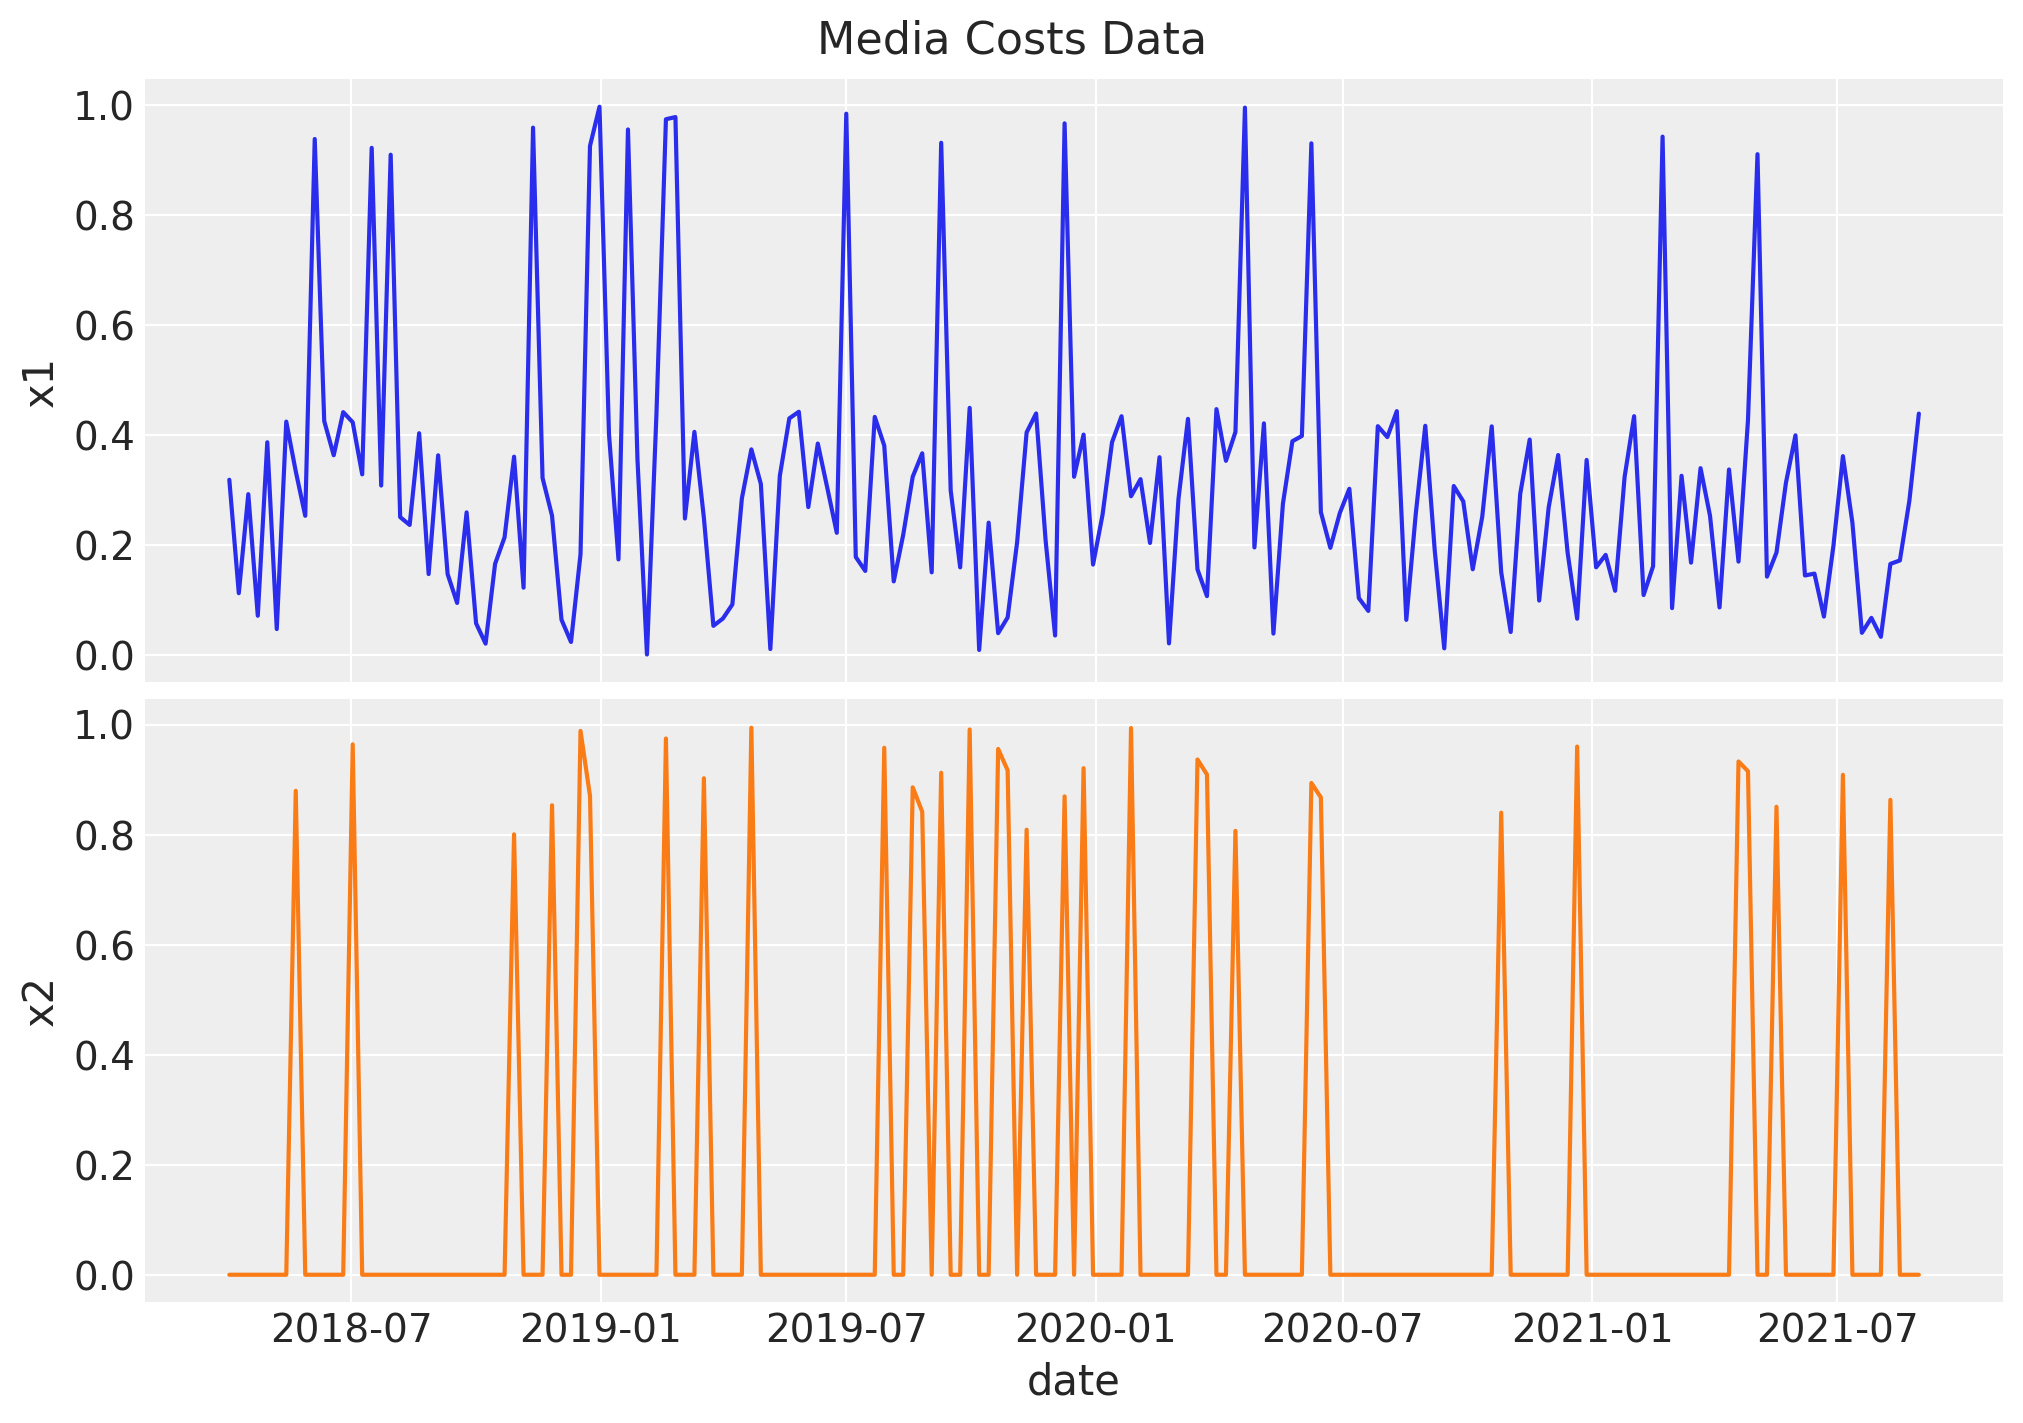

In [6]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

In [7]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True).eval().flatten())

df["x2_adstock"] = (geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True).eval().flatten())

In [8]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(x=df["x1_adstock"].to_numpy(), lam=lam1).eval()

df["x2_adstock_saturated"] = logistic_saturation(x=df["x2_adstock"].to_numpy(), lam=lam2).eval()

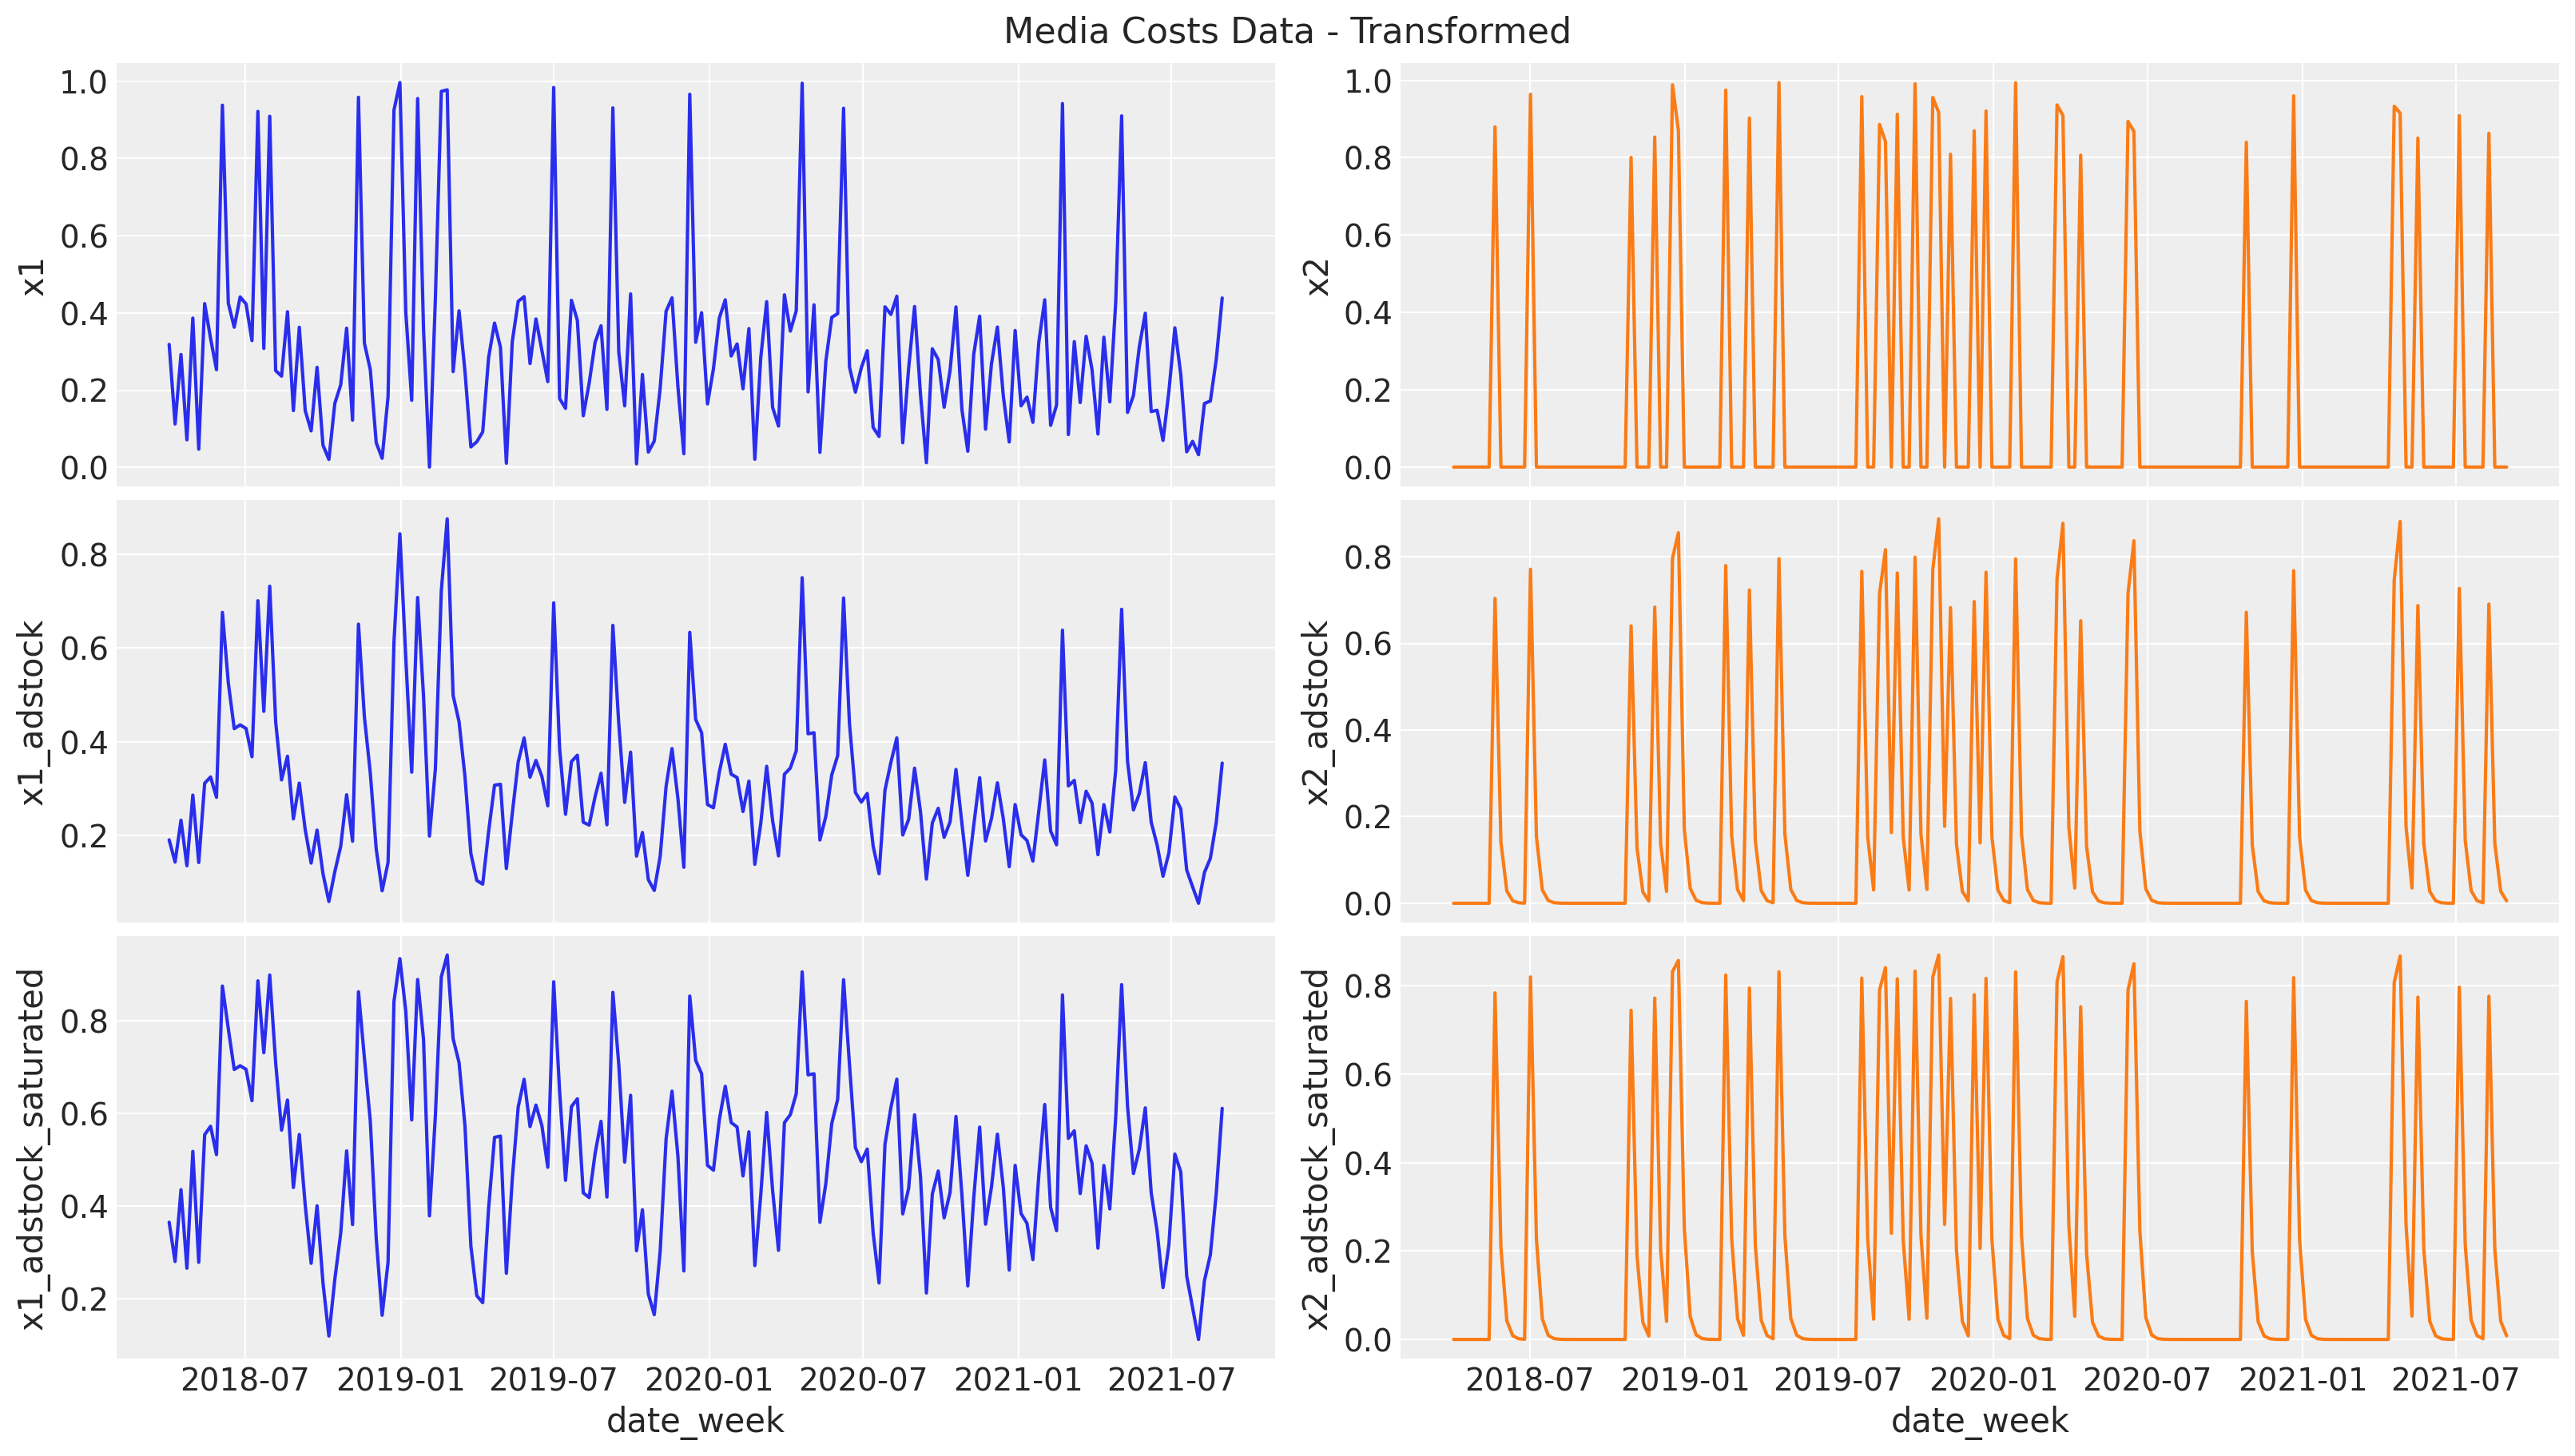

In [9]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

In [10]:
#Trend and Seasonal components
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1/4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

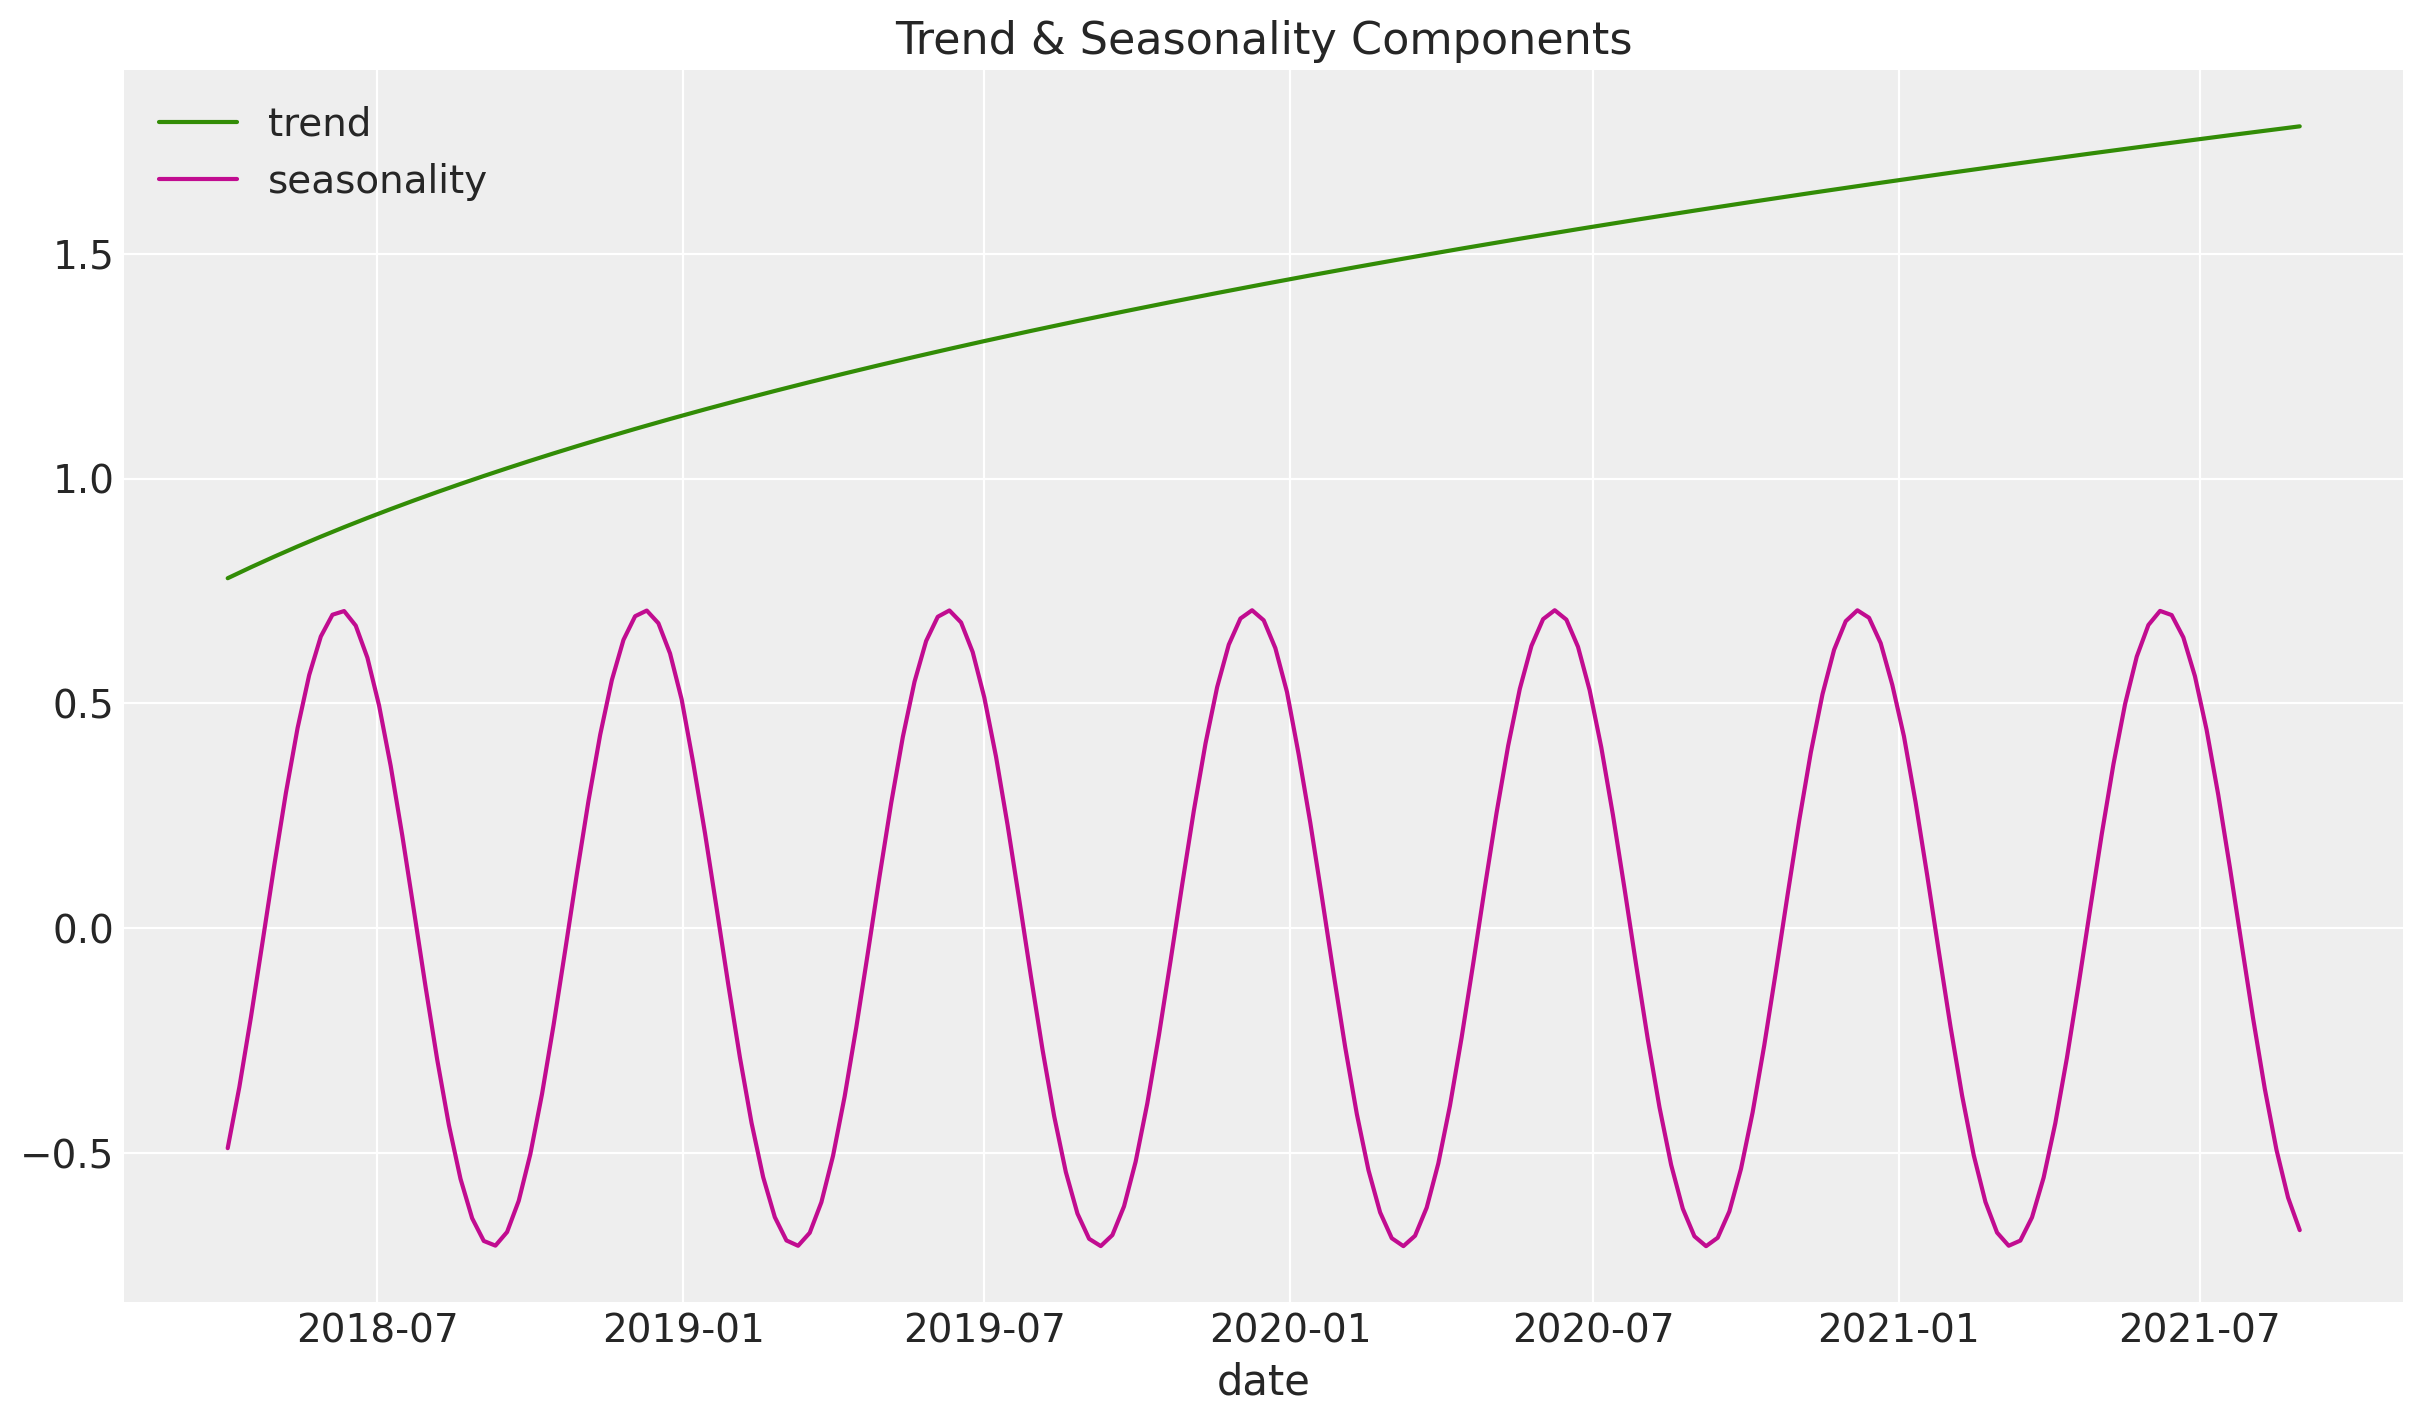

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

In [12]:
# Control variables

df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

In [13]:
# Target Variable

In [14]:

df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n) # White noise
amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]

df["y"] = amplitude * ( df["intercept"] + df["trend"] + df["seasonality"] + 1.5 * df["event_1"] + 2.5 * df["event_2"] + beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + df["epsilon"] )

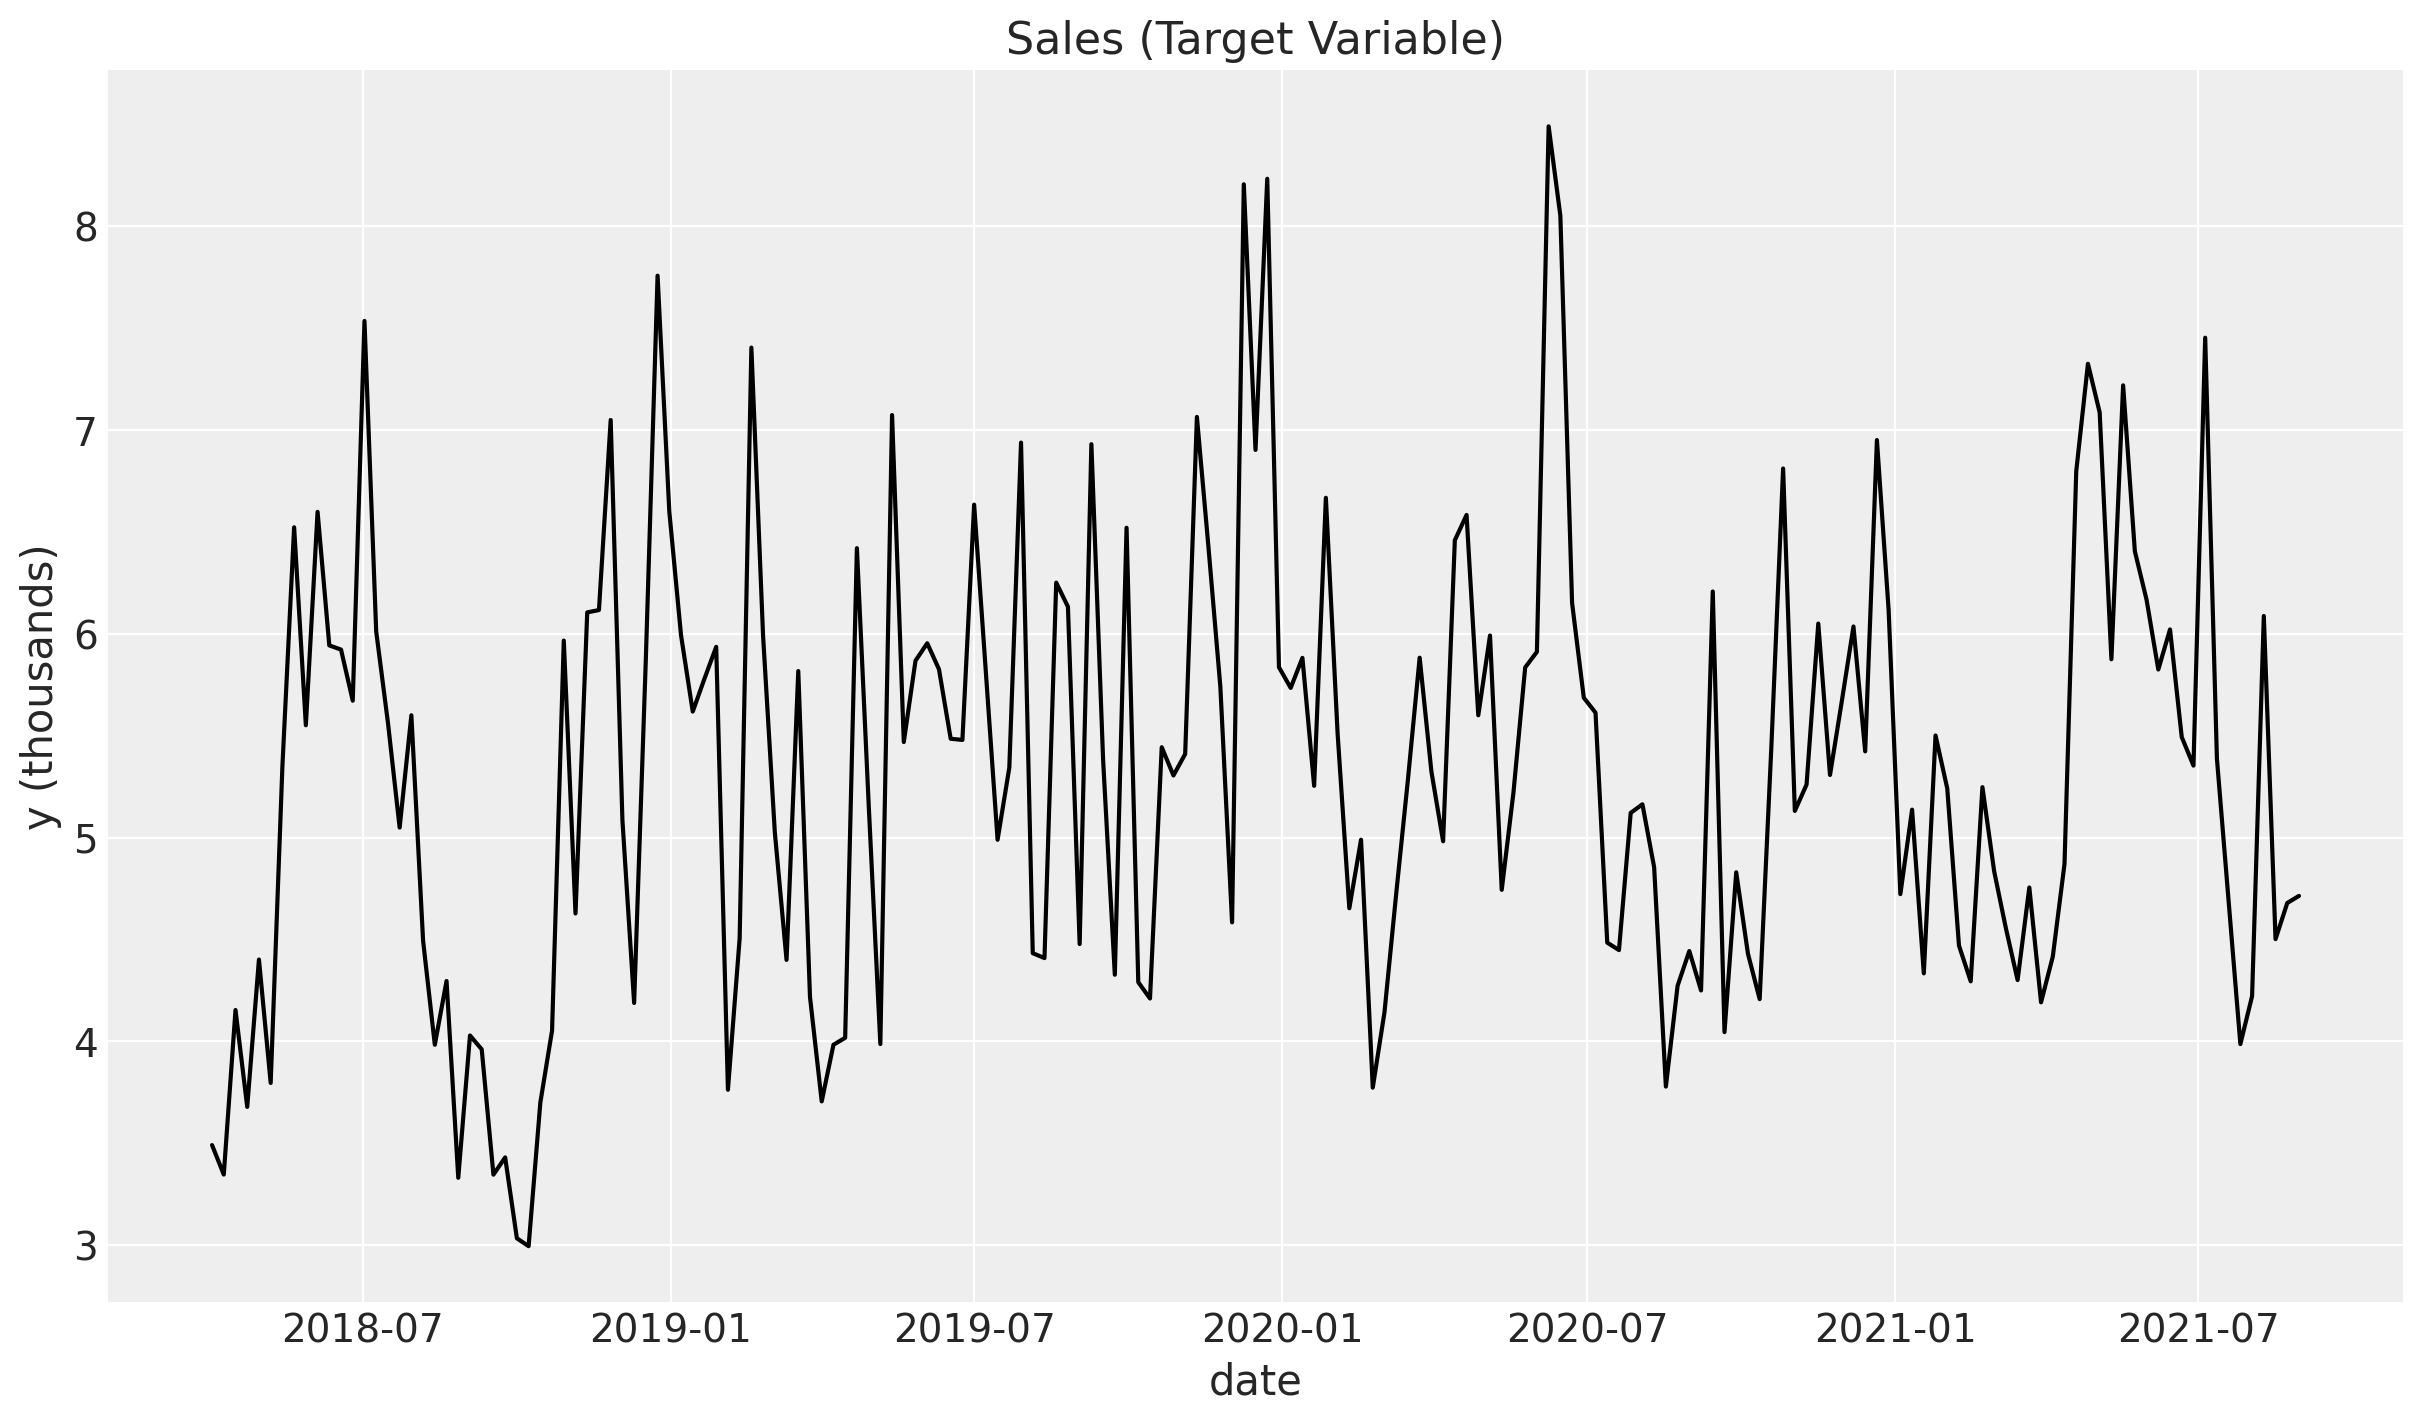

In [15]:
fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

In [16]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.81
Contribution Share of x2: 0.19


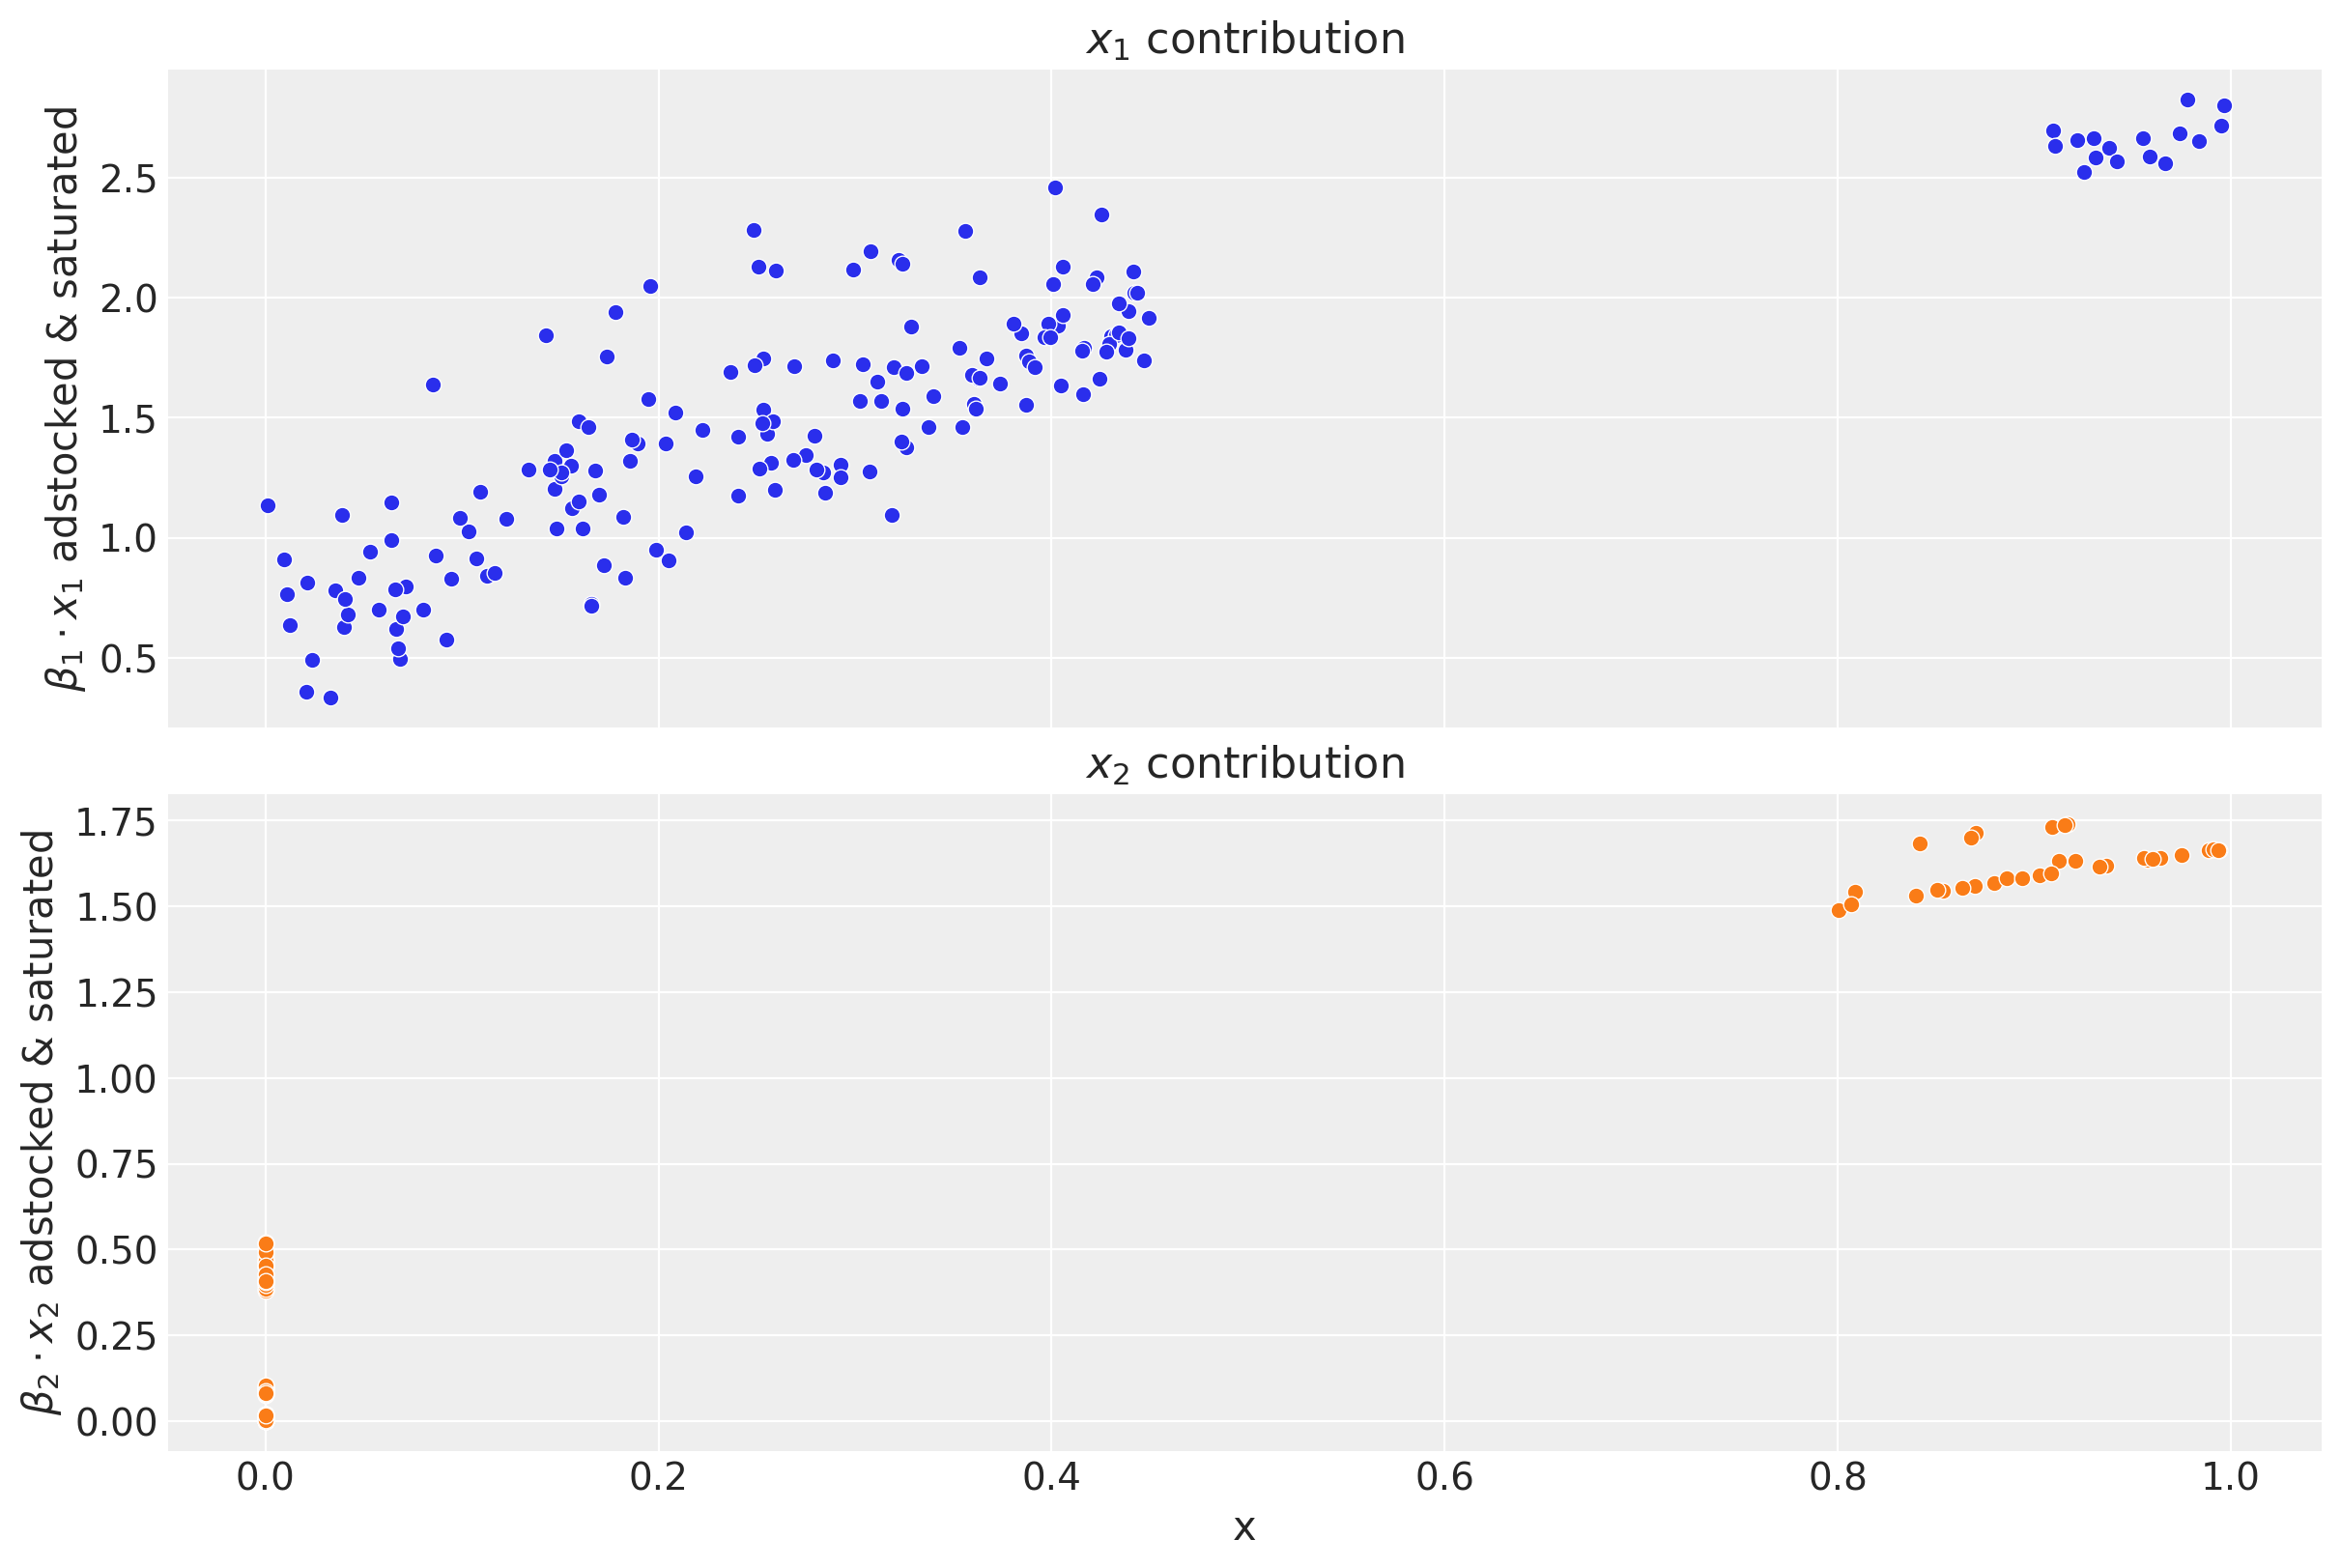

In [17]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

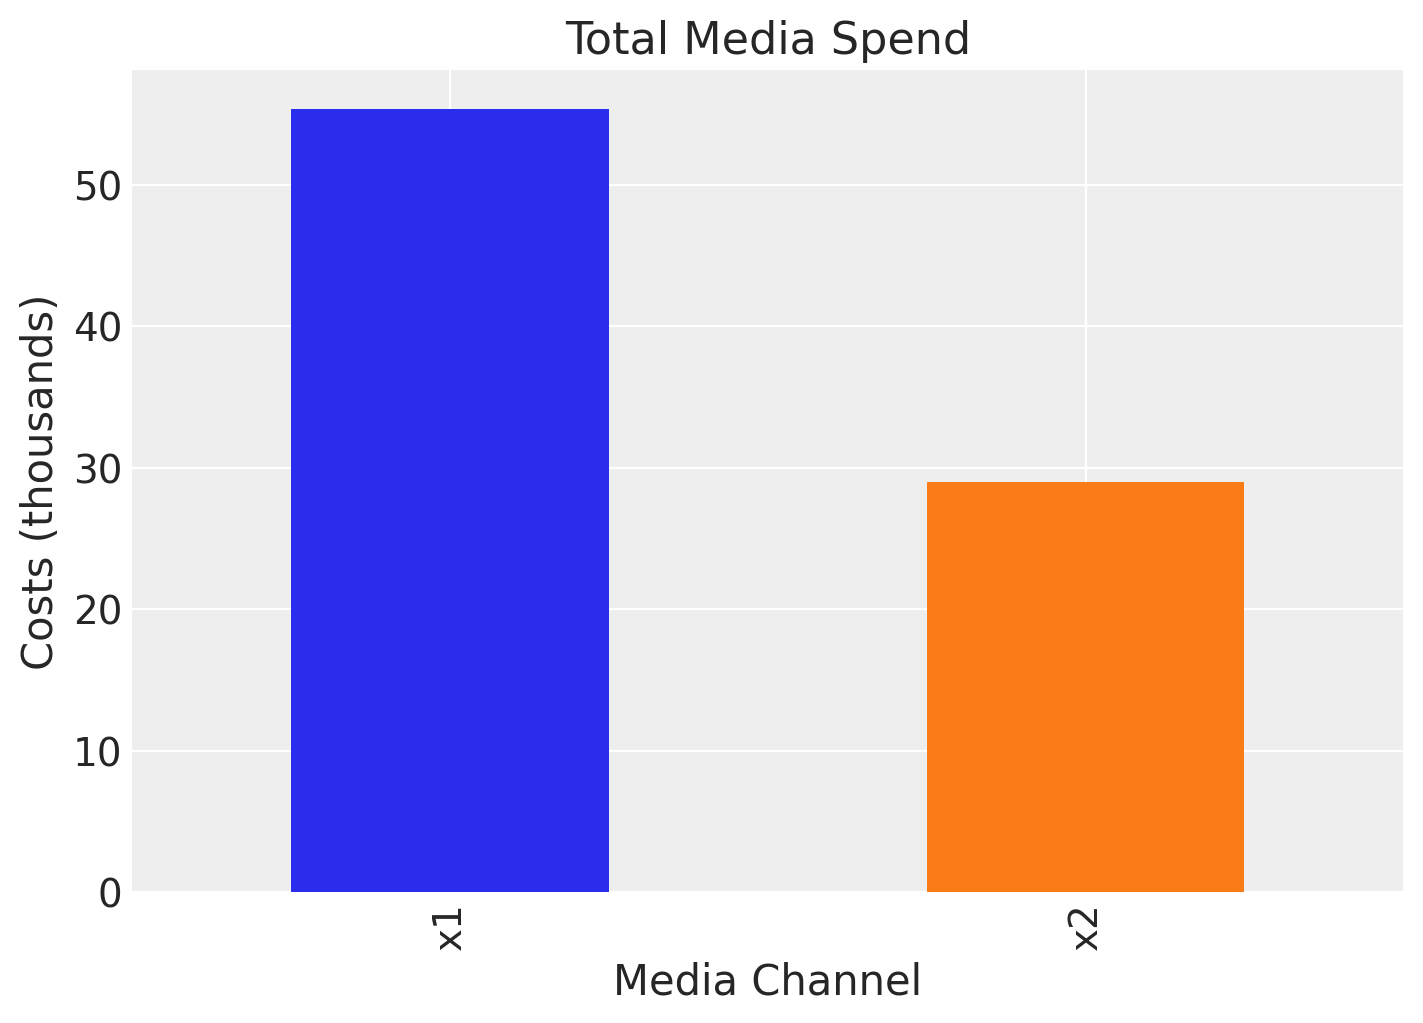

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2"]].sum().plot(kind="bar", color=["C0", "C1"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");

In [19]:
# ROAS approximation
# [ ] Explain this formula
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

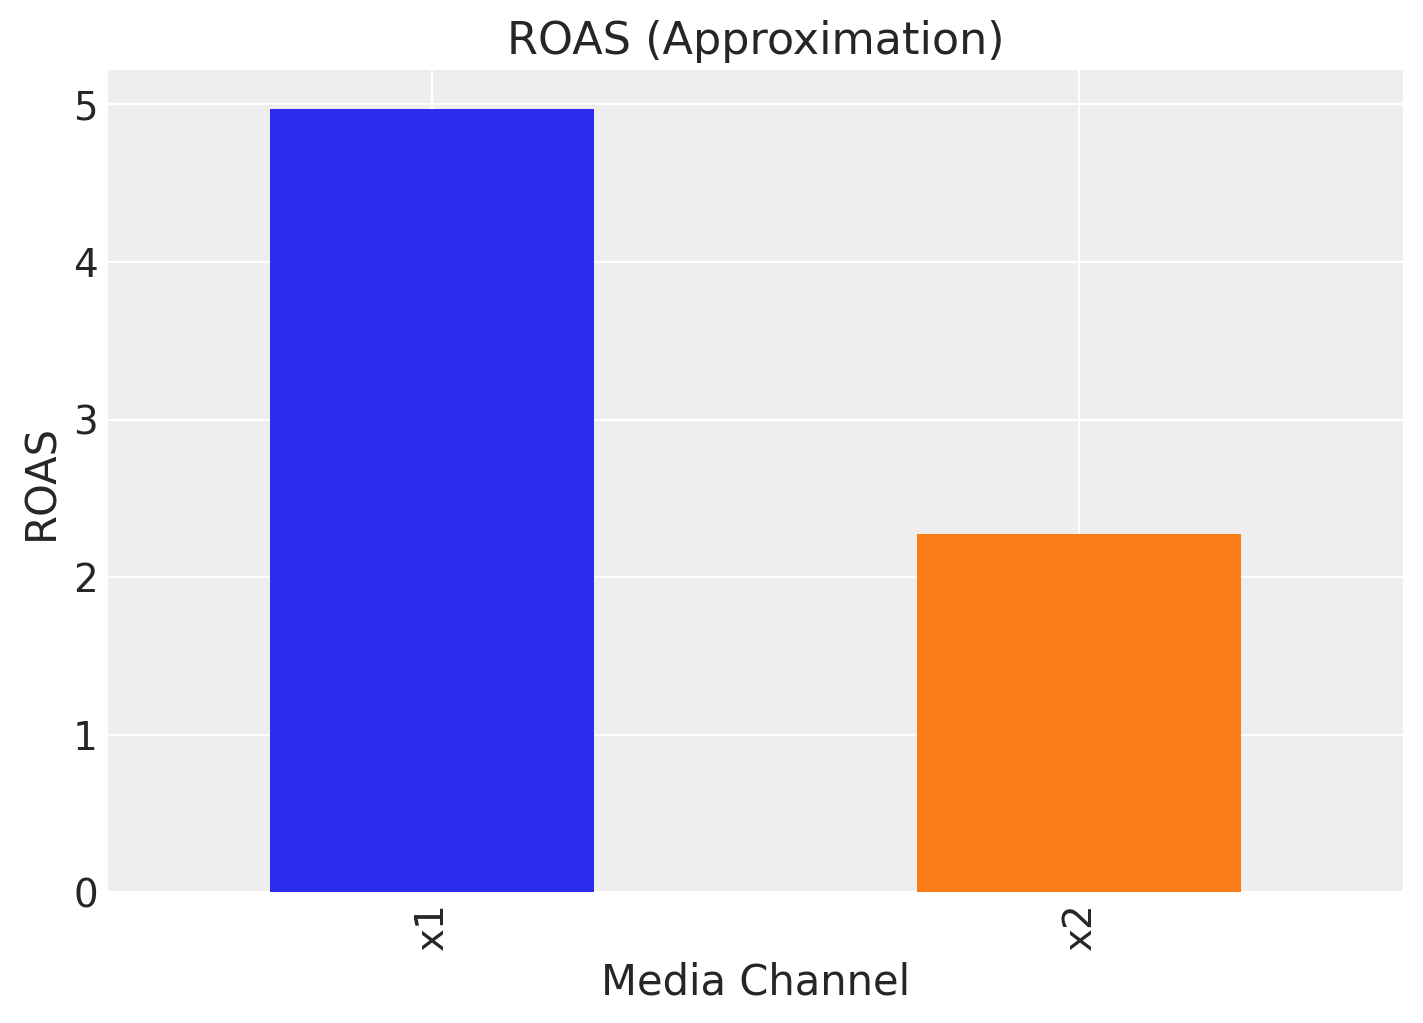

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

In [21]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

date_week         y        x1   x2  event_1  event_2  dayofyear
0 2018-04-02  3.490150  0.318580  0.0      0.0      0.0         92
1 2018-04-09  3.345307  0.112388  0.0      0.0      0.0         99
2 2018-04-16  4.153242  0.292400  0.0      0.0      0.0        106
3 2018-04-23  3.677788  0.071399  0.0      0.0      0.0        113
4 2018-04-30  4.401077  0.386745  0.0      0.0      0.0        120

# Modelling

In [22]:
# trend feature

data["t"] = range(n)

data.head()

date_week         y        x1   x2  event_1  event_2  dayofyear  t
0 2018-04-02  3.490150  0.318580  0.0      0.0      0.0         92  0
1 2018-04-09  3.345307  0.112388  0.0      0.0      0.0         99  1
2 2018-04-16  4.153242  0.292400  0.0      0.0      0.0        106  2
3 2018-04-23  3.677788  0.071399  0.0      0.0      0.0        113  3
4 2018-04-30  4.401077  0.386745  0.0      0.0      0.0        120  4

In [23]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.65632
x2    0.34368
dtype: float64

In [24]:
# specify sigma per channel

HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()
prior_sigma.tolist()

[2.1775326025486734, 1.1402608773919387]

In [25]:
X = data.drop("y", axis=1)
y = data["y"]

In [26]:
dummy_model = DelayedSaturatedMMM(date_column= "", channel_columns="", adstock_max_lag = 4)
dummy_model.default_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

In [27]:
custom_beta_channel_prior = {"beta_channel": {"sigma": prior_sigma, "dims": ("channel",)}}
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}
my_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': array([2.1775326 , 1.14026088]),
  'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

In [28]:
sampler_config = {"progressbar": True}

In [29]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

In [30]:
mmm.fit(X=X, y=y, target_accept = 0.95, chains = 4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

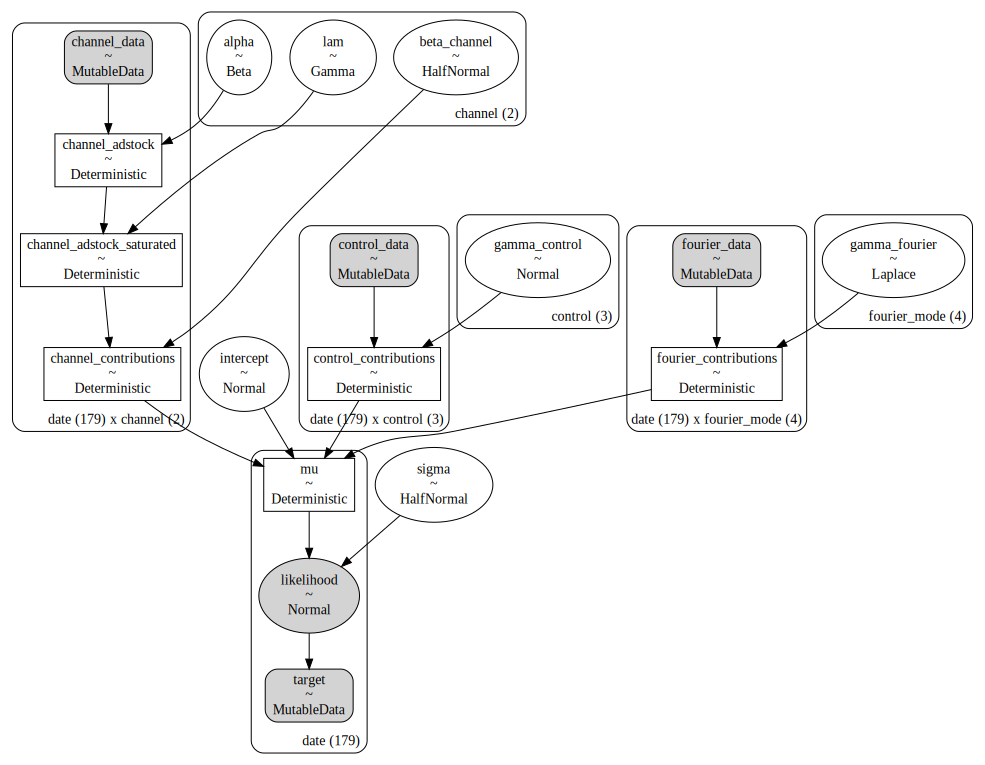

In [ ]:
pm.model_to_graphviz(model=mmm.model)

In [ ]:
mmm.fit_result

<xarray.Dataset>
Dimensions:                    (chain: 4, draw: 1000, control: 3,
                                fourier_mode: 4, channel: 2, date: 179)
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * control                    (control) <U7 'event_1' 'event_2' 't'
  * fourier_mode               (fourier_mode) <U11 'sin_order_1' ... 'cos_ord...
  * channel                    (channel) <U2 'x1' 'x2'
  * date                       (date) datetime64[ns] 2018-04-02 ... 2021-08-30
Data variables: (12/13)
    intercept                  (chain, draw) float64 0.3358 0.3283 ... 0.3312
    gamma_control              (chain, draw, control) float64 0.2931 ... 0.00...
    gamma_fourier              (chain, draw, fourier_mode) float64 -0.0003607...
    beta_channel               (chain, draw, channel) float64 0.3862 ... 0.2287
    alpha                      (chain, draw, channel) float64 0.4738 ... 0.1461
    lam                        (chain, draw, channel) float64 3.65 ... 4.275
    ...                         ...
    channel_adstock            (chain, draw, date, channel) float64 0.1686 .....
    channel_adstock_saturated  (chain, draw, date, channel) float64 0.2984 .....
    channel_contributions      (chain, draw, date, channel) float64 0.1152 .....
    control_contributions      (chain, draw, date, control) float64 0.0 ... 0...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 -0.0...
    mu                         (chain, draw, date) float64 0.3921 ... 0.5947
Attributes:
    created_at:                 2023-11-08T15:52:53.341651
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.2
    sampling_time:              385.90048146247864
    tuning_steps:               1000

In [ ]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
)

mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept                   0.343  0.013   0.318    0.366  ...    0.000    3003.0    2922.0    1.0
beta_channel[x1]            0.354  0.018   0.323    0.390  ...    0.000    2790.0    2991.0    1.0
beta_channel[x2]            0.266  0.089   0.189    0.381  ...    0.002    1333.0     994.0    1.0
alpha[x1]                   0.397  0.030   0.343    0.453  ...    0.000    3230.0    2890.0    1.0
alpha[x2]                   0.192  0.040   0.112    0.265  ...    0.001    1975.0    2244.0    1.0
lam[x1]                     4.061  0.364   3.400    4.759  ...    0.004    3465.0    2534.0    1.0
lam[x2]                     3.169  1.189   0.986    5.401  ...    0.021    1355.0    1000.0    1.0
gamma_control[event_1]      0.241  0.030   0.186    0.299  ...    0.000    5869.0    2687.0    1.0
gamma_control[event_2]      0.320  0.030   0.264    0.376  ...    0.000    4868.0    2464.0    1.0
gamma_control[t]            0.001  0.000   0.001    0.001  ...    0.000    3707.0    2993.0    1.0
gamma_fourier[sin_order_1]  0.003  0.003  -0.003    0.009  ...    0.000    4817.0    2784.0    1.0
gamma_fourier[cos_order_1]  0.003  0.003  -0.003    0.009  ...    0.000    6479.0    2437.0    1.0
gamma_fourier[sin_order_2] -0.056  0.003  -0.062   -0.050  ...    0.000    5351.0    3039.0    1.0
gamma_fourier[cos_order_2]  0.061  0.003   0.055    0.067  ...    0.000    5057.0    3357.0    1.0
sigma                       0.029  0.002   0.026    0.032  ...    0.000    4760.0    2727.0    1.0

[15 rows x 9 columns]

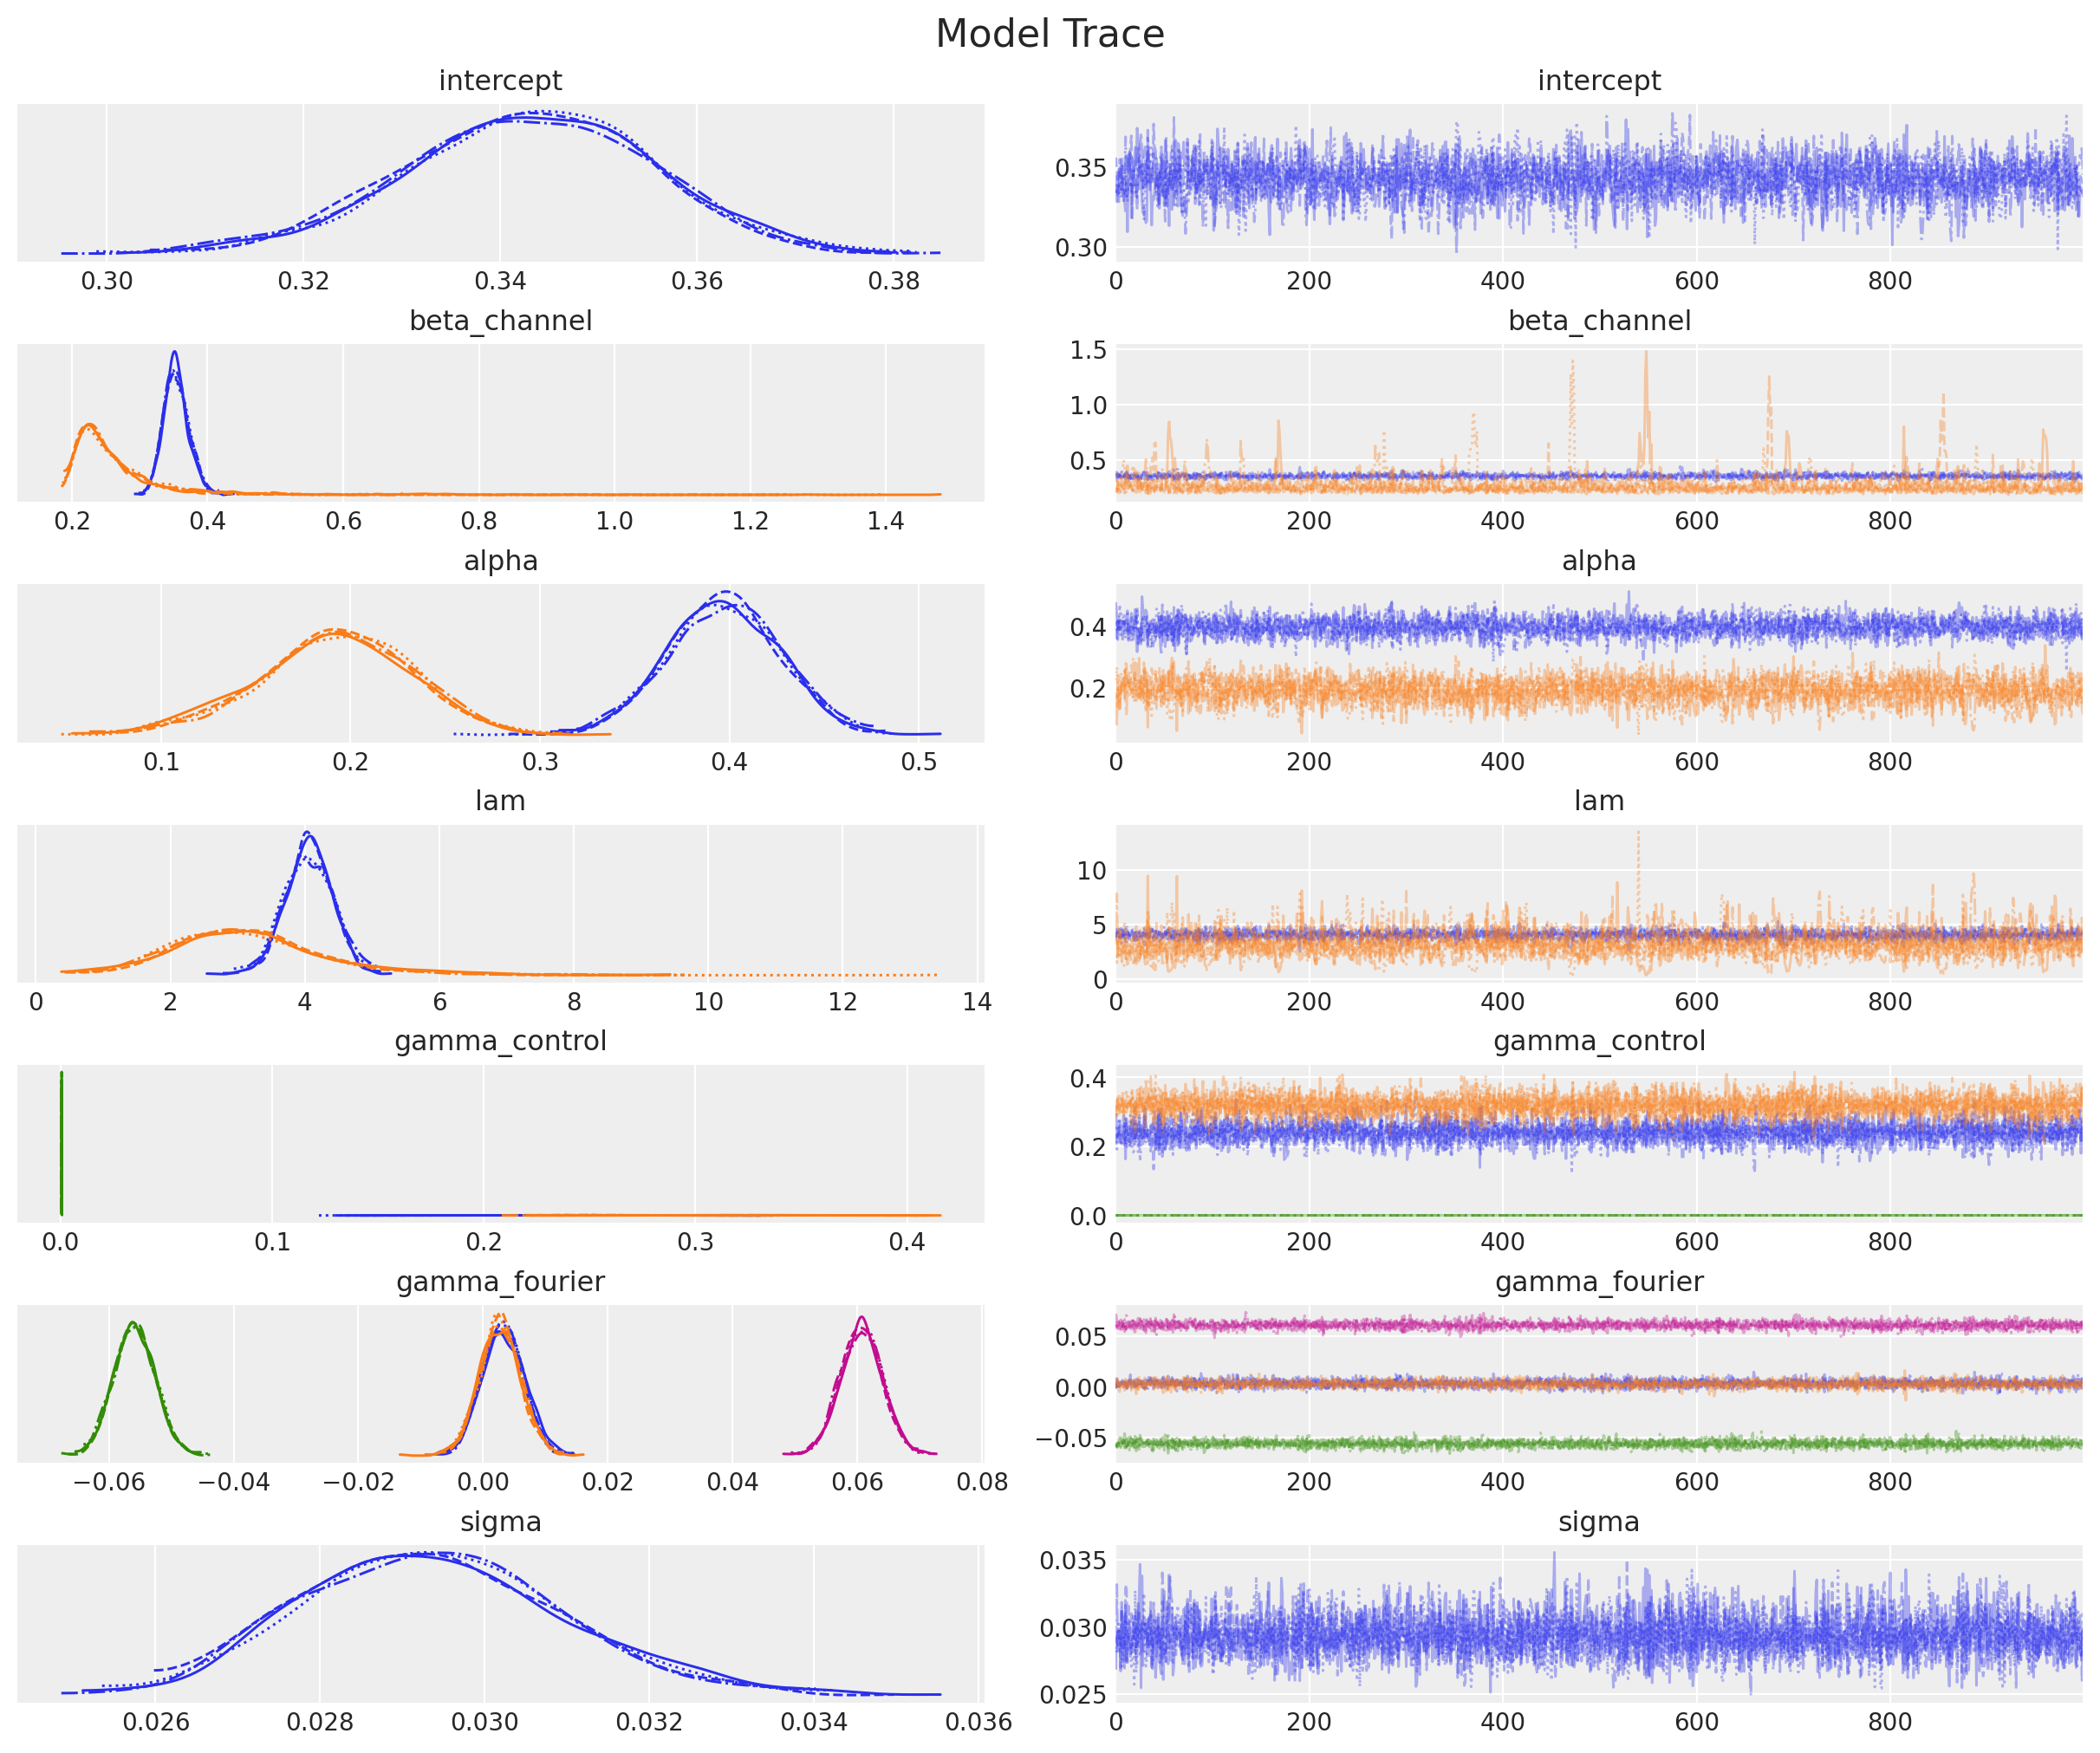

In [ ]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [ ]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

<xarray.Dataset>
Dimensions:     (date: 179, sample: 4000)
Coordinates:
  * date        (date) datetime64[ns] 2018-04-02 2018-04-09 ... 2021-08-30
  * sample      (sample) object MultiIndex
  * chain       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    likelihood  (date, sample) float64 0.4233 0.404 0.4103 ... 0.6265 0.6336
Attributes:
    created_at:                 2023-11-08T17:00:00.417731
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.2

In [29]:
mmm.plot_posterior_predictive(original_scale=True);

RuntimeError: The model hasn't been fit yet, call .fit() first

In [ ]:
mmm.plot_components_contributions();

In [ ]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
    ],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "Channel 1": "C0",
            "Channel 2": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

In [ ]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

x1   x2  event_1  event_2  ...  cos_order_1  sin_order_2  cos_order_2  intercept
date                                         ...                                                  
2018-04-02  1.115799  0.0      0.0      0.0  ...    -0.000271     0.011226    -0.515176   2.911508
2018-04-09  0.854125  0.0      0.0      0.0  ...    -0.003024     0.124081    -0.497401   2.911508
2018-04-16  1.325983  0.0      0.0      0.0  ...    -0.005733     0.229773    -0.450915   2.911508
2018-04-23  0.808261  0.0      0.0      0.0  ...    -0.008359     0.322203    -0.378402   2.911508
2018-04-30  1.575895  0.0      0.0      0.0  ...    -0.010864     0.396035    -0.284047   2.911508

[5 rows x 10 columns]

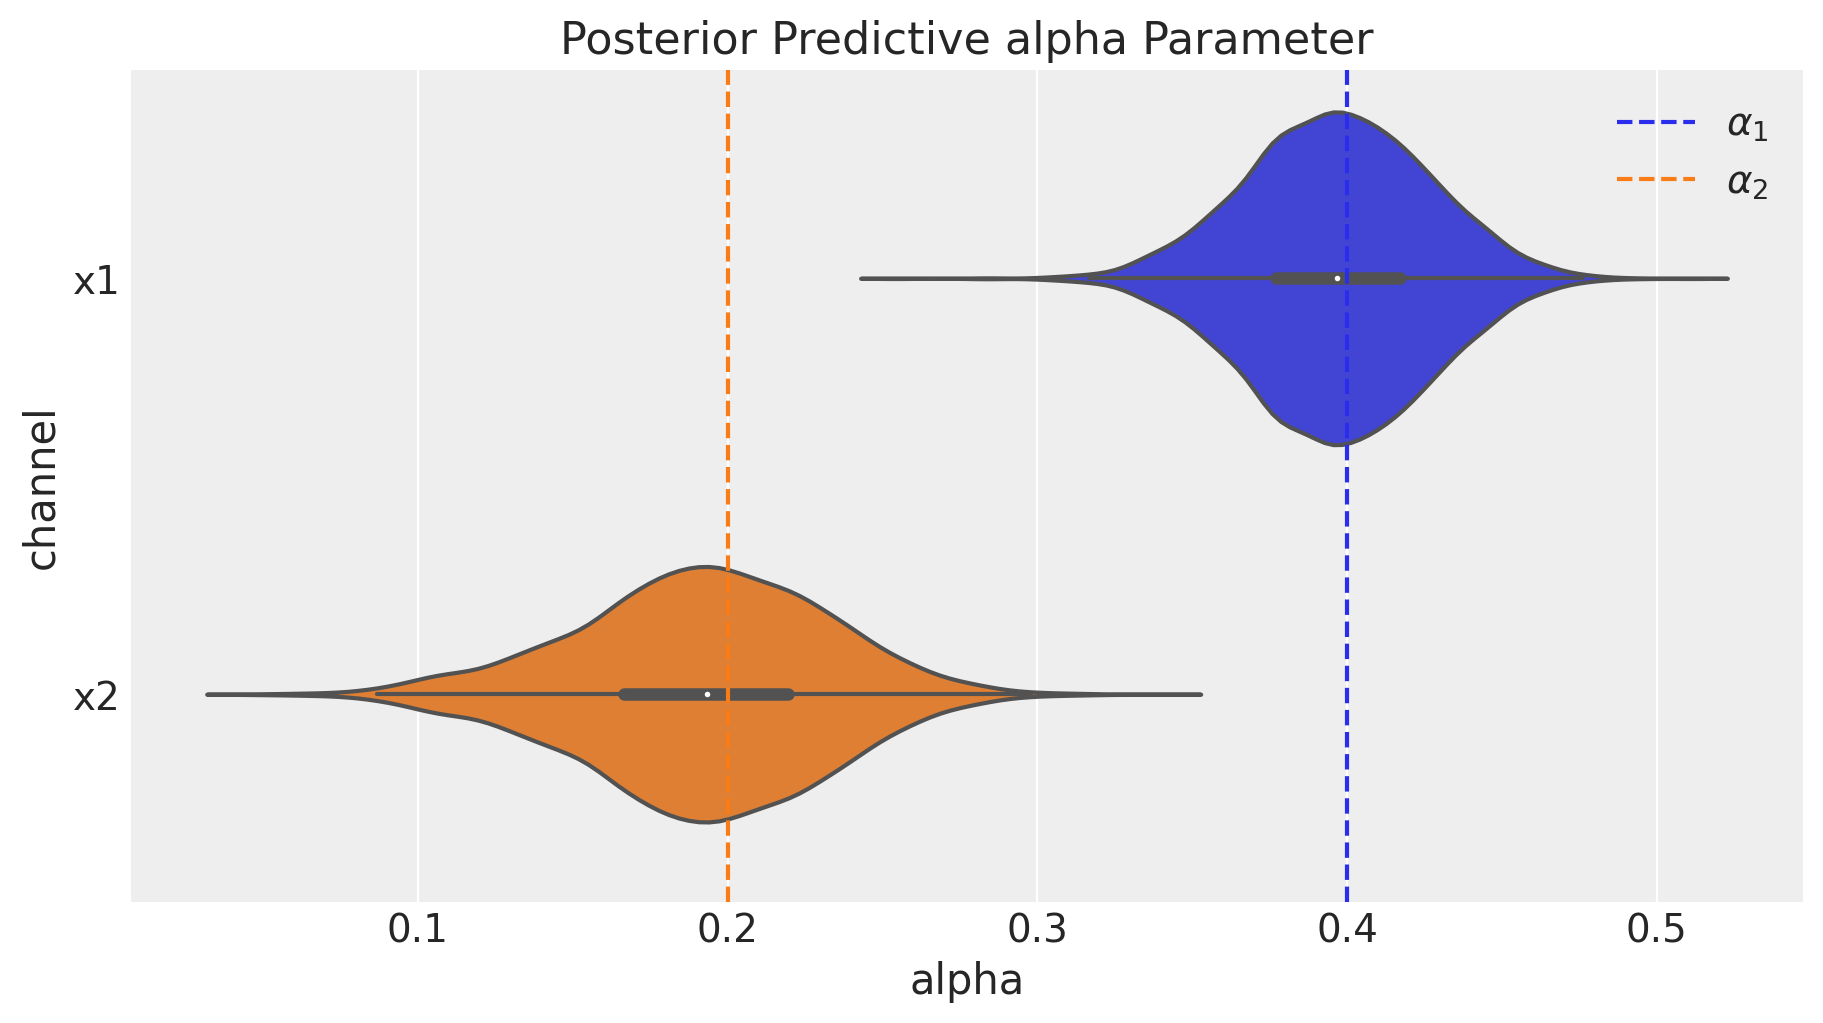

In [ ]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

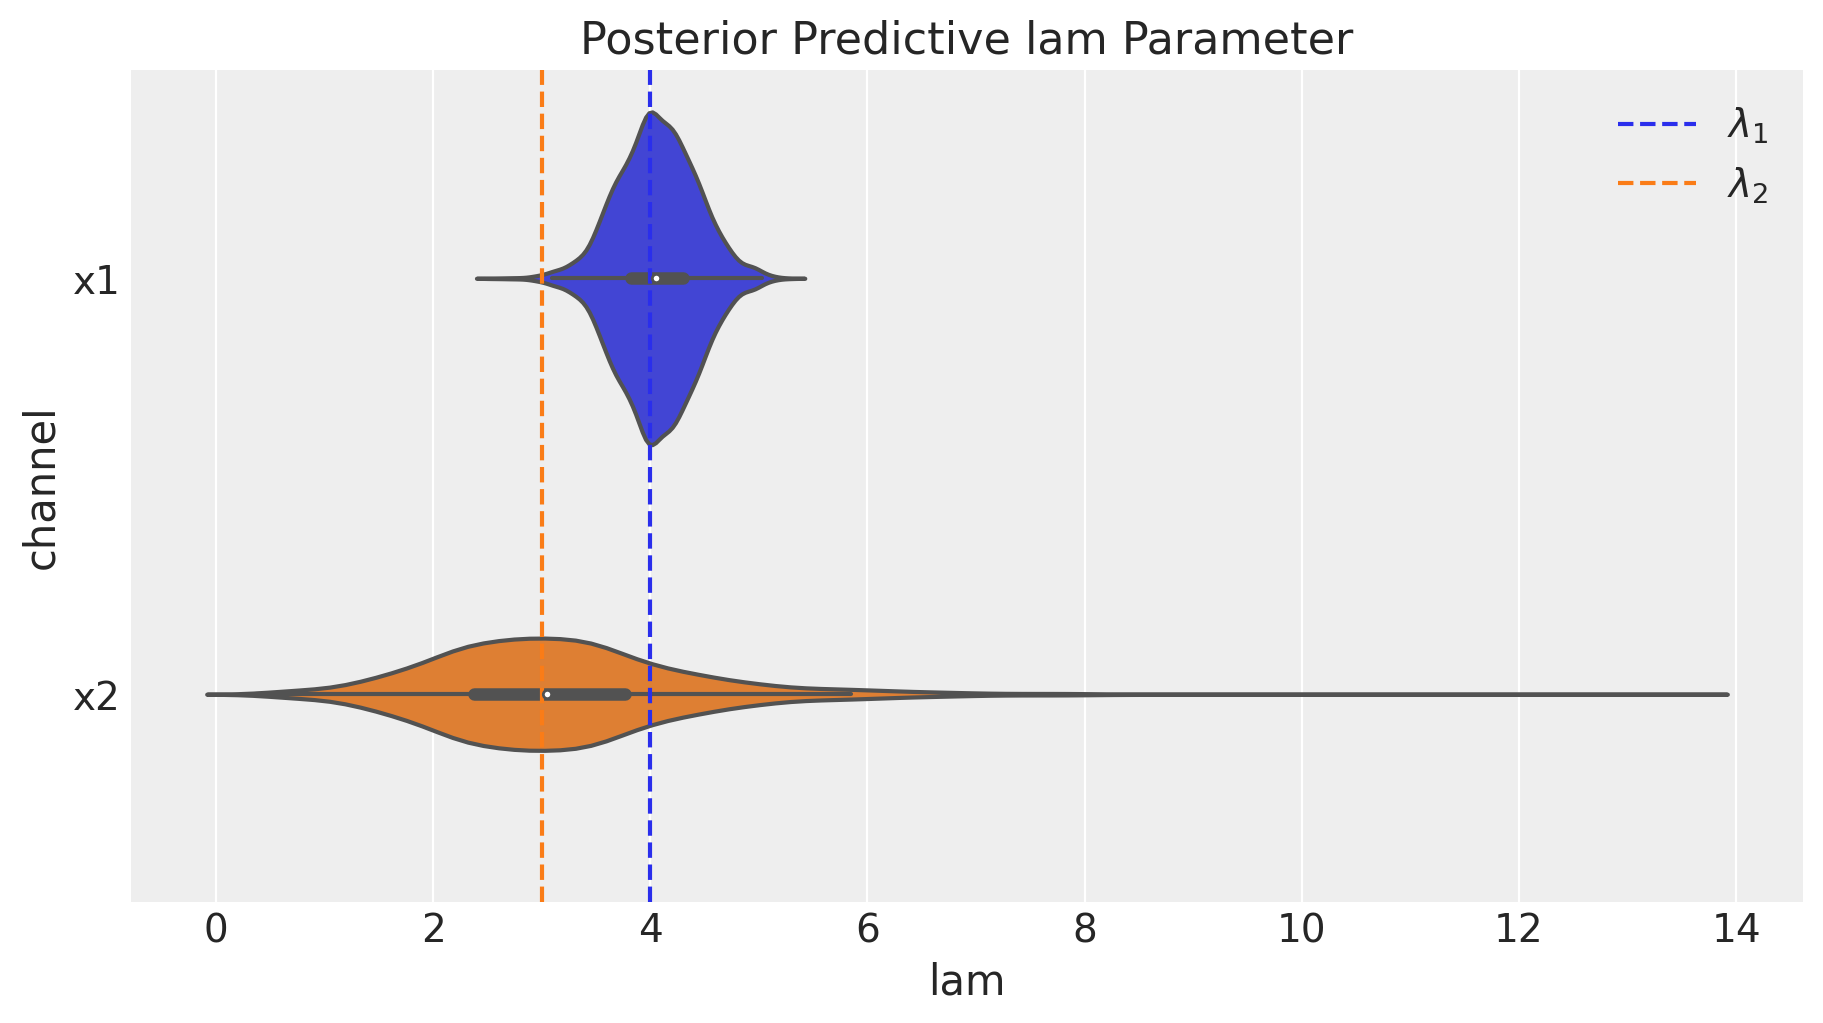

In [ ]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

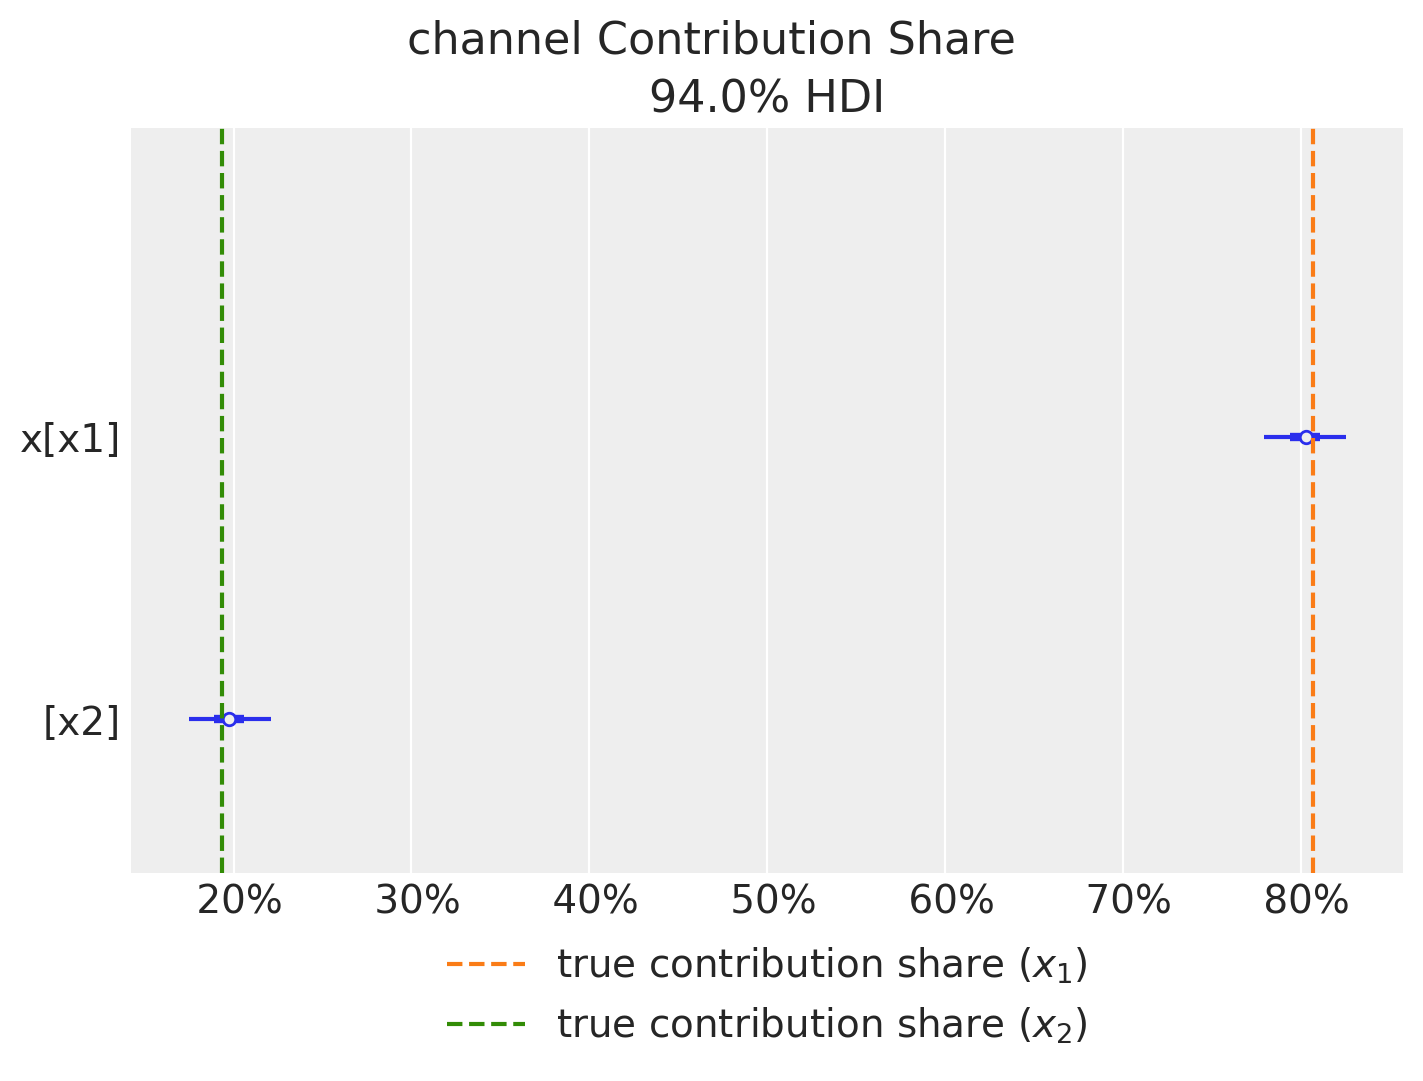

In [ ]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

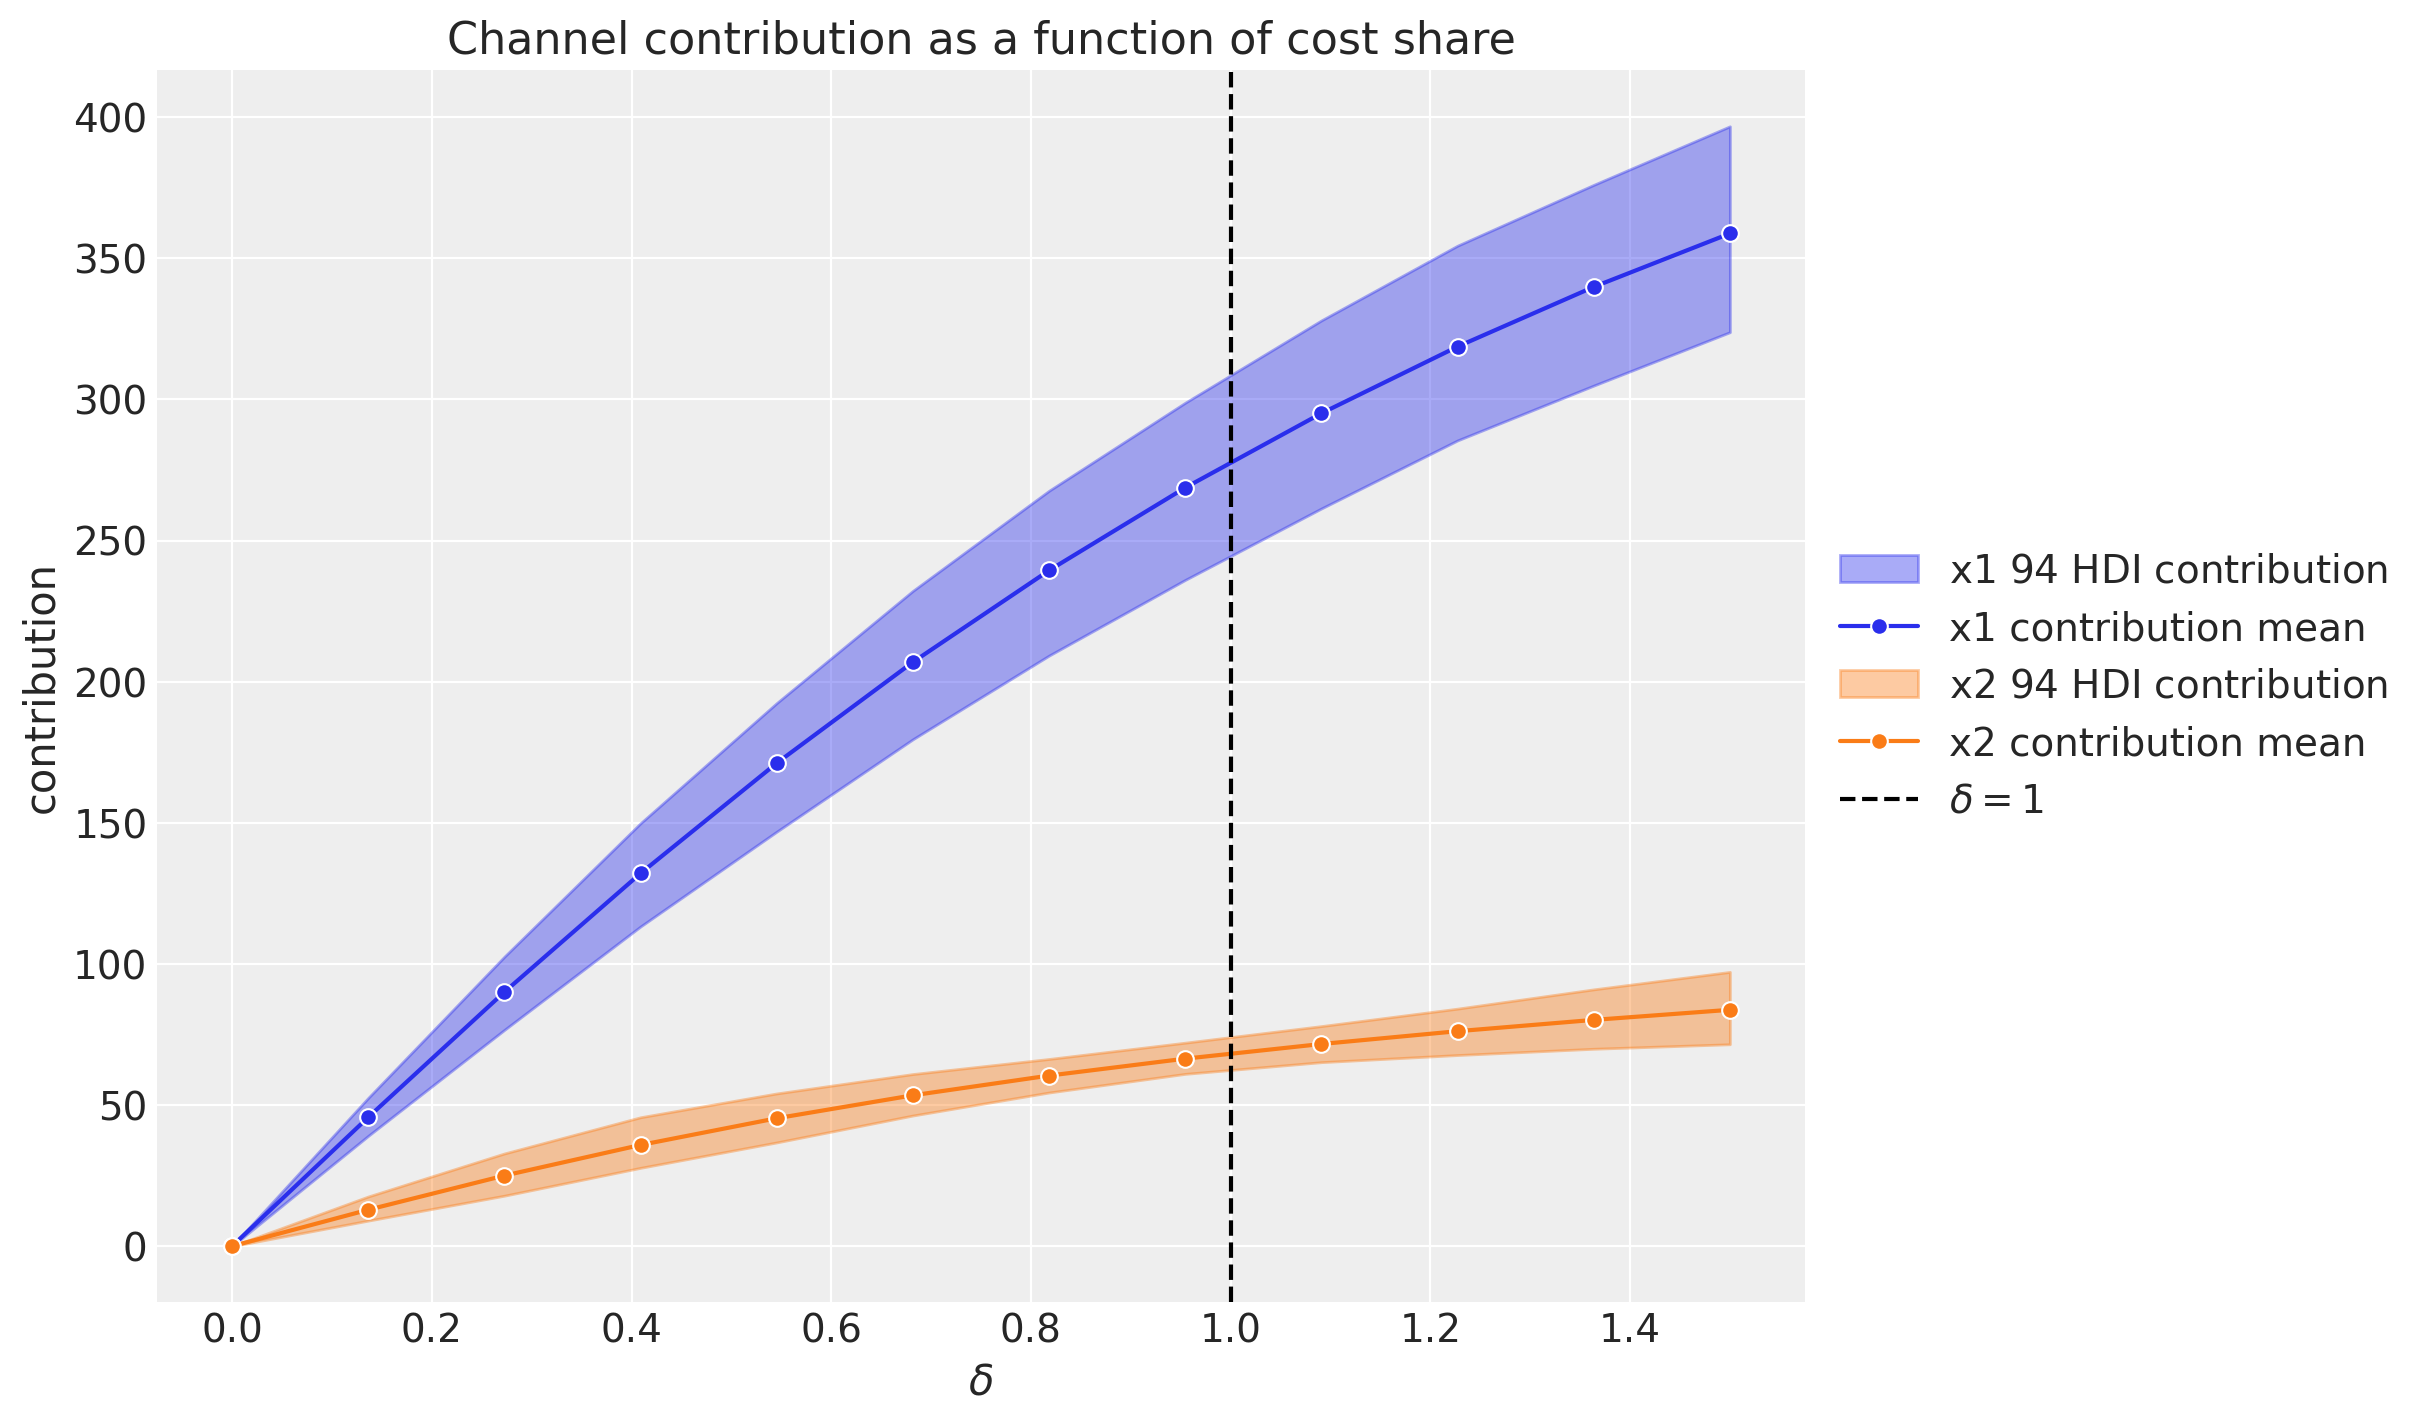

In [ ]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12);

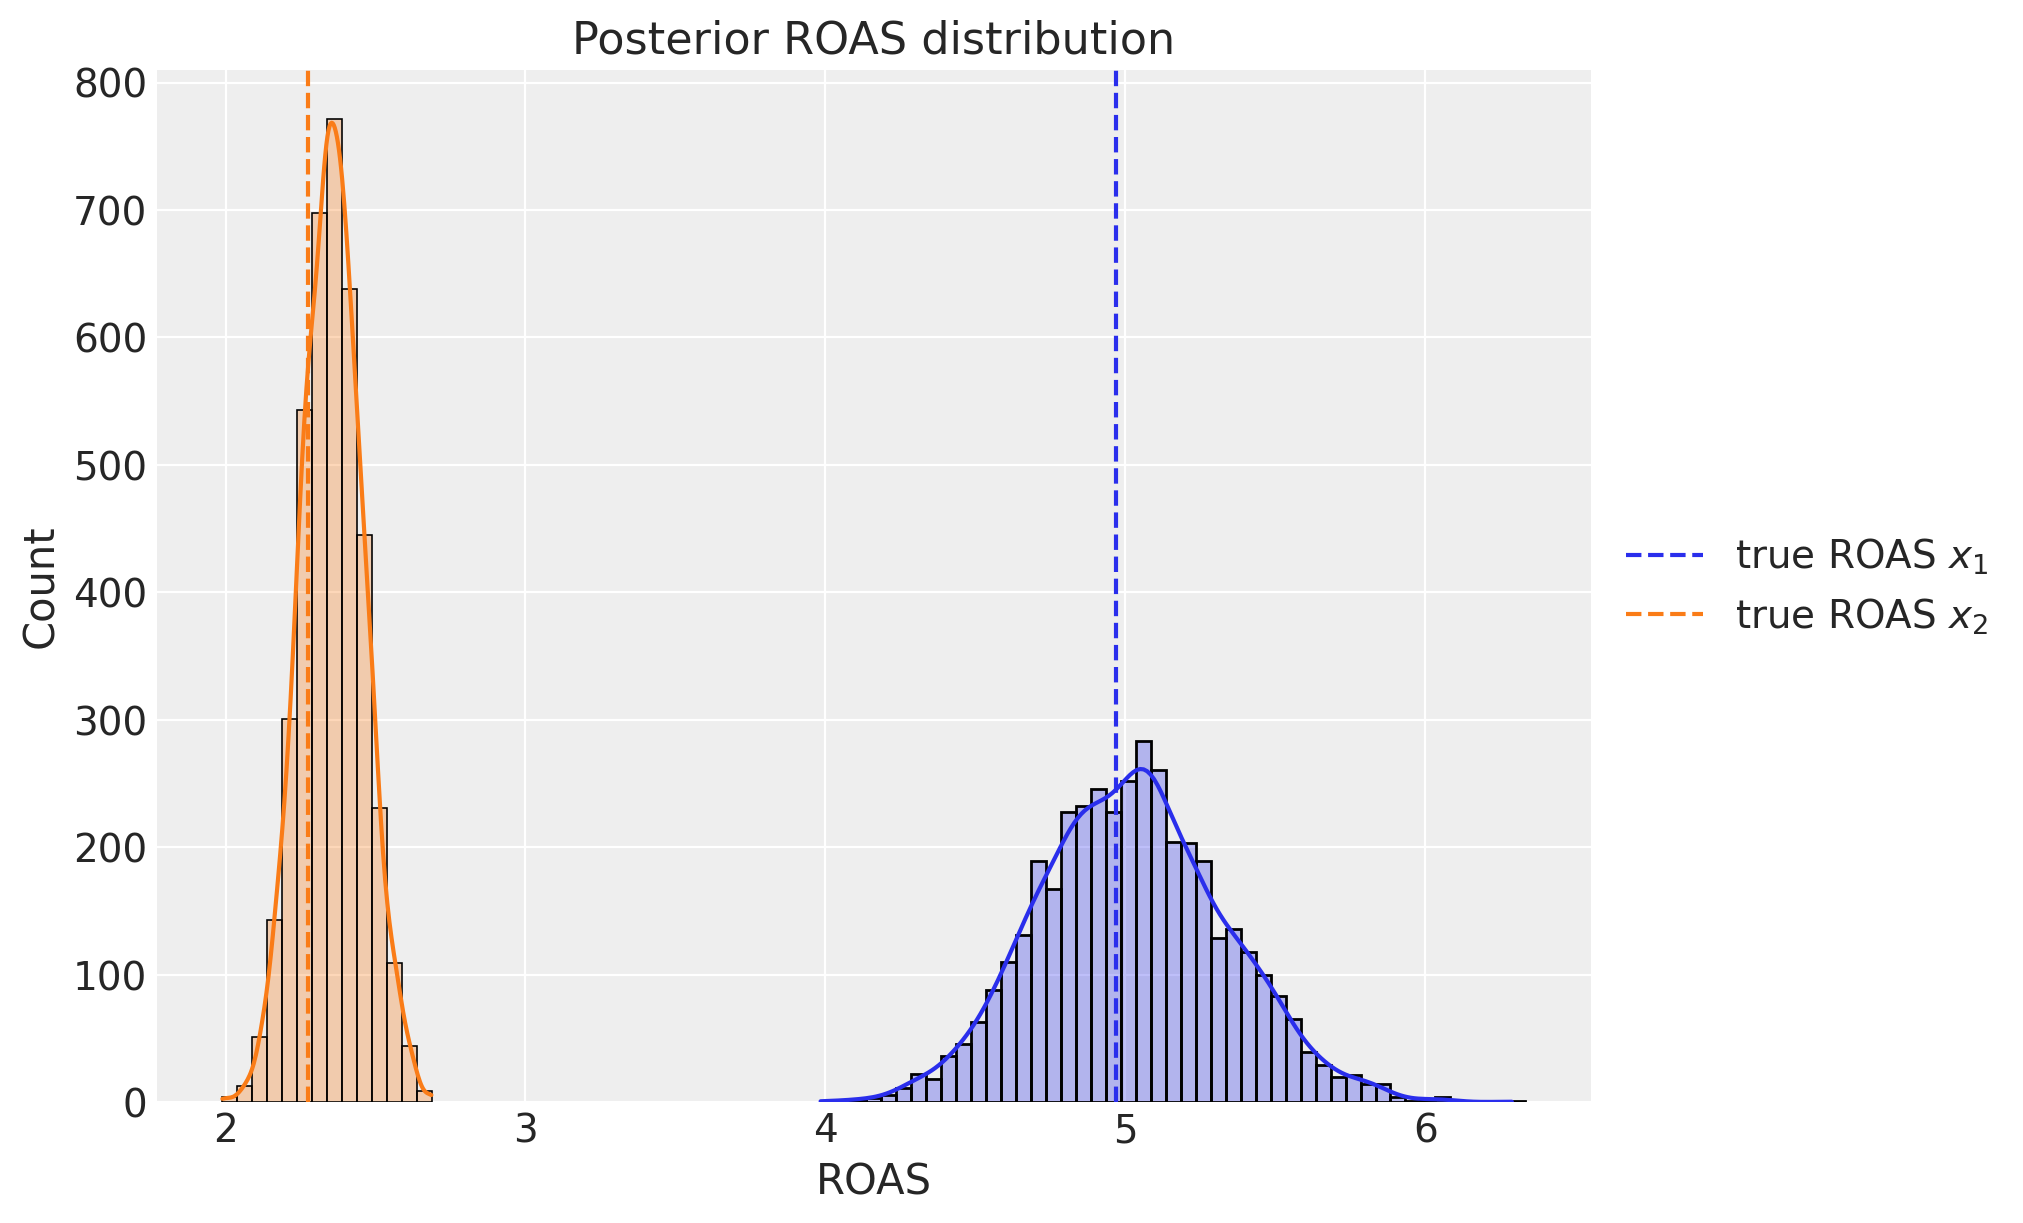

In [ ]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");